# Network embedding

In this notebook we aim to derive a node embedding for the regulatory network of U2OS cells that we derived in our preceeding analyses. To this end, we will train a Graph-convolutional AutoEncoder. To assess the stability of the embeddings we will experiment with different input features, training objectives and initializations and compare the clustering of the inferred latent spaces i.a. to embeddings obtained from a DeepWalk model. On the basis of those analyses we will finally identify a stable node embedding for the genes in the input regulatory network. Those embeddings will span our estimate of the regulatory state in U2OS cells.

---

## 0. Environmental setup

First, we will load all required libraries.

In [10]:
import pandas as pd
import networkx as nx
import numpy as np
import seaborn as sns
import sys
import os
import random
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import community as community_louvain
from torch_geometric.data import Data
from torch import LongTensor, FloatTensor
from node2vec import Node2Vec
from torch_geometric.nn import GAE
from torch_geometric.utils import train_test_split_edges, from_networkx
import torch_geometric.transforms as T
from torch_geometric.nn import InnerProductDecoder
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import scanpy as sc
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import adjusted_mutual_info_score
from scipy.stats import spearmanr, pearsonr

sys.path.append("../../../")

from src.utils.torch.network import *
from src.utils.notebooks.ppi.embedding import *
from src.utils.basic.io import get_genesets_from_gmt_file
from src.models.ae import CustomGAE, GCNEncoder

seed = 1234

%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

---

## 1. Read in data

Next, we will read in the regulatory graph data along side with a scRNA-seq data set and a number of hallmark geneset information. The latter two will be used to define further node features and update the correlation information for the interactions in the graph.

In [11]:
spearman_interactome = nx.read_gpickle(
    "../../../data/ppi/inference_results/conf_hub_spearman_sol.pkl"
)
print(nx.info(spearman_interactome))

Name: conf_hub_spearman_sol
Type: Graph
Number of nodes: 163
Number of edges: 328
Average degree:   4.0245


<IPython.core.display.Javascript object>

In [12]:
gex_adata = sc.read("../../../data/gex/scrnaseq/fucci_adata.h5")
gex_adata.var_names_make_unique()
gex_data = pd.DataFrame(
    gex_adata.X, columns=gex_adata.var_names, index=gex_adata.obs_names
)
gex_data.columns = [c.upper() for c in gex_data.columns]
gex_data = gex_data.loc[
    :, set(spearman_interactome.nodes()).intersection(gex_data.columns)
]

<IPython.core.display.Javascript object>

In addition to the 50 Hallmark gene sets, we also load the gene sets corresponding to pathways involved in mechanotransduction: cell cycle control, regulation of chromatin organization and actin cytoskeleton, DNA damage repair, cell death and transcription factors.

In [13]:
cc_genes = set(
    pd.read_csv("../../../data/other/reactome_cell_cycle.txt", index_col=0).index
)
co_genes = set(
    pd.read_csv("../../../data/other/reactome_chrom_org.txt", index_col=0).index
)
dr_genes = set(
    pd.read_csv("../../../data/other/reactome_dna_repair.txt", index_col=0).index
)
cd_genes = set(
    pd.read_csv("../../../data/other/reactome_cell_death.txt", index_col=0).index
)
cr_genes = set(
    pd.read_csv("../../../data/other/kegg_reg_act_cytoskeleton.txt", index_col=0).index
)
tfs = set(pd.read_csv("../../../data/other/human_tf_list.txt", index_col=0).index)

spec_results = pd.read_csv(
    "../../../data/other/specificity_screen_results.csv", index_col=0
)
spec_results = spec_results.loc[spec_results["selected"]]
spec_orf_targets = set(spec_results.index)
hallmark_geneset_dict = get_genesets_from_gmt_file(
    "../../../data/other/h.all.v7.4.symbols.gmt"
)

<IPython.core.display.Javascript object>

---
---

## 2. Preprocessing

We will now set the respective node and edge attributes computed based on the previously loaded information. Note, that the single-cell gene expression data is min-max-scaled.

### 2.1. Attribute setting

In [14]:
gex_data_z = pd.DataFrame(
    MinMaxScaler().fit_transform(gex_data),
    index=gex_data.index,
    columns=gex_data.columns,
)

<IPython.core.display.Javascript object>

In [15]:
for node in spearman_interactome.nodes(data=True):
    node[-1]["sc_gex"] = np.array(gex_data_z.loc[:, node[0]])
    node[-1]["name"] = node[0]
    node[-1]["cell_cycle"] = node[0] in cc_genes
    node[-1]["chromatin_org"] = node[0] in co_genes
    node[-1]["dna_repair"] = node[0] in dr_genes
    node[-1]["cytoskeleton_org"] = node[0] in cr_genes
    node[-1]["cell_death"] = node[0] in cd_genes
    node[-1]["tf"] = node[0] in tfs
    node[-1]["spec_target"] = node[0] in spec_orf_targets

    gene_memberships = []
    for geneset in hallmark_geneset_dict.values():
        if node[0] in geneset:
            gene_memberships.append(1.0)
        else:
            gene_memberships.append(0.0)

    node[-1]["hallmark"] = np.array(gene_memberships)
    node[-1]["sc_gex_hallmark"] = np.concatenate(
        [node[-1]["sc_gex"], node[-1]["hallmark"]]
    )

for edge in spearman_interactome.edges(data=True):
    edge[-1]["spearmanr"] = spearmanr(
        gex_data.loc[:, edge[0]], gex_data.loc[:, edge[1]]
    )[0]
    edge[-1]["pearsonr"] = pearsonr(gex_data.loc[:, edge[0]], gex_data.loc[:, edge[1]])[
        0
    ]

<IPython.core.display.Javascript object>

---

### 2.2 Data preparation

Next, we transform the graph into a data object complient with the used pytorch_geometric framework to learn the graph embeddings.

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

graph_data = from_networkx(spearman_interactome)
graph_data.id = torch.FloatTensor(np.identity(len(spearman_interactome)))
graph_data = T.ToDevice(
    device,
    attrs=[
        "id",
        "sc_gex",
        "pbulk_gex",
        "hallmark",
        "sc_gex_hallmark",
        "pbulk_gex_hallmark",
    ],
)(graph_data)

<IPython.core.display.Javascript object>

---
---

## 3. Node embeddings


After having finally prepared the data, we can now start inferring node embeddings from the data. For each model type, we will vary the initialization 5 times using different random seeds. In a first step, we will assess the similarity between the inferred latent spaces by pairwise comparing the hierarchical co-clustering of the inferred spaces pairwise using the adjusted mutual information.
In the second step, we will assess the individual inferred latent spaces for a fixed random initialization and compare the similarity of the inferred embeddings between the different model setups in a similar fashion.

---

### 3.1. Assessing the stability of the inferred latent spaces

#### 3.1.1. Node2Vec

We will first start with a simple baseline model that is purely based on the network topology and embedds the nodes via encoding neighborhood simularity using random walks on the graph. The model requires a number of hyperparameters, which we initially keep constant for the stability assessment.

In [17]:
seeds = [1234, 2345, 3456, 4567, 5678]
latent_dims = [32, 64, 128]

<IPython.core.display.Javascript object>

100%|██████████| 100/100 [00:50<00:00,  1.98it/s]

Final loss: 0.9565745039684016


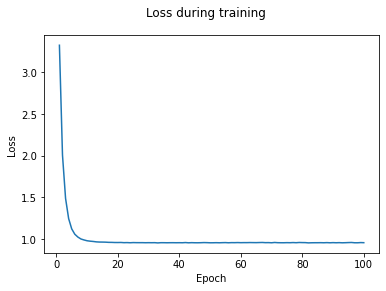

100%|██████████| 100/100 [00:49<00:00,  2.01it/s]

Final loss: 0.9552900325961229


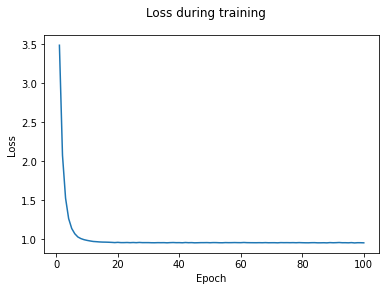

100%|██████████| 100/100 [00:50<00:00,  1.99it/s]

Final loss: 0.9554190286775914


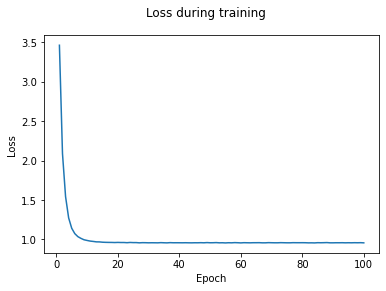

100%|██████████| 100/100 [00:50<00:00,  2.00it/s]

Final loss: 0.9565193754870717


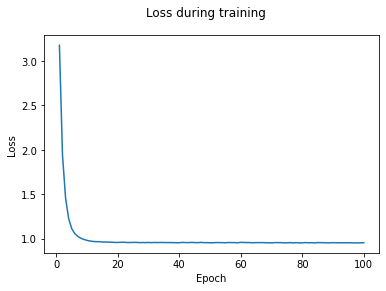

100%|██████████| 100/100 [00:49<00:00,  2.00it/s]

Final loss: 0.9543255087805957


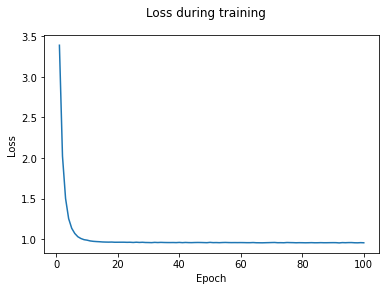

100%|██████████| 5/5 [00:02<00:00,  2.23it/s]


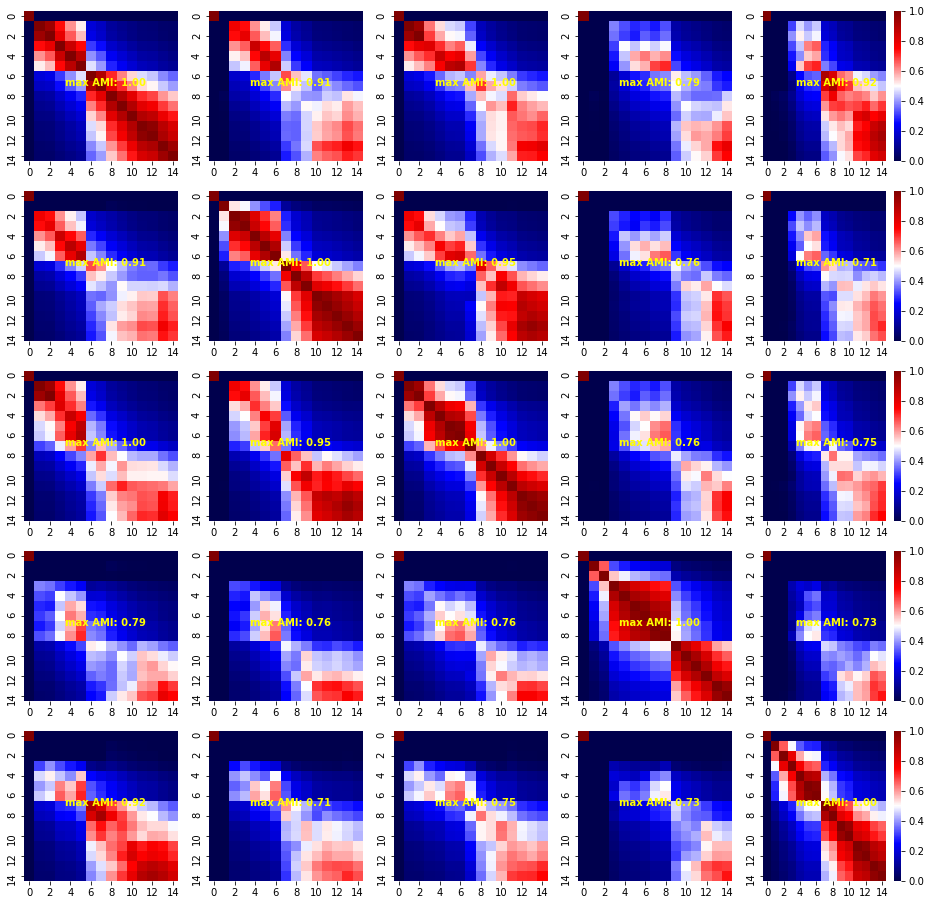

100%|██████████| 100/100 [00:51<00:00,  1.95it/s]

Final loss: 0.9601940294591392


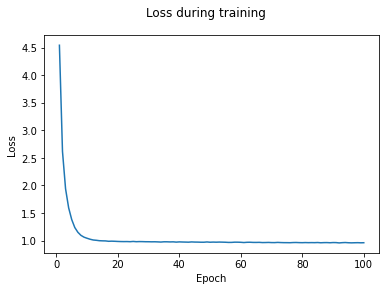

100%|██████████| 100/100 [00:50<00:00,  1.98it/s]

Final loss: 0.9572951531991726


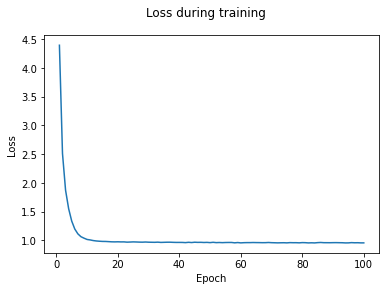

100%|██████████| 100/100 [00:50<00:00,  1.99it/s]


Final loss: 0.9671956271660037


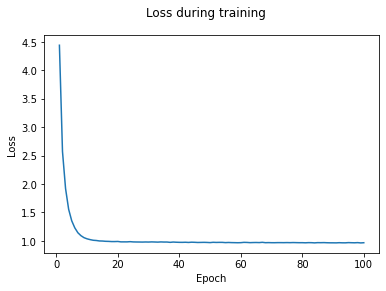

100%|██████████| 100/100 [00:50<00:00,  1.99it/s]

Final loss: 0.9586110580258254


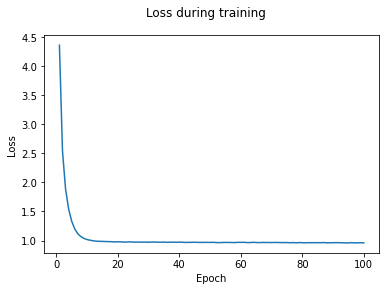

100%|██████████| 100/100 [00:50<00:00,  1.96it/s]

Final loss: 0.9467777842428626


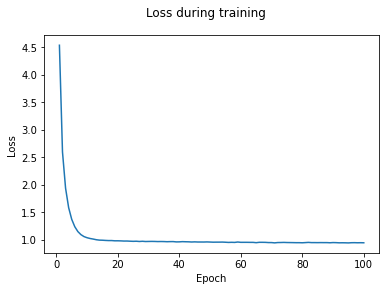

100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


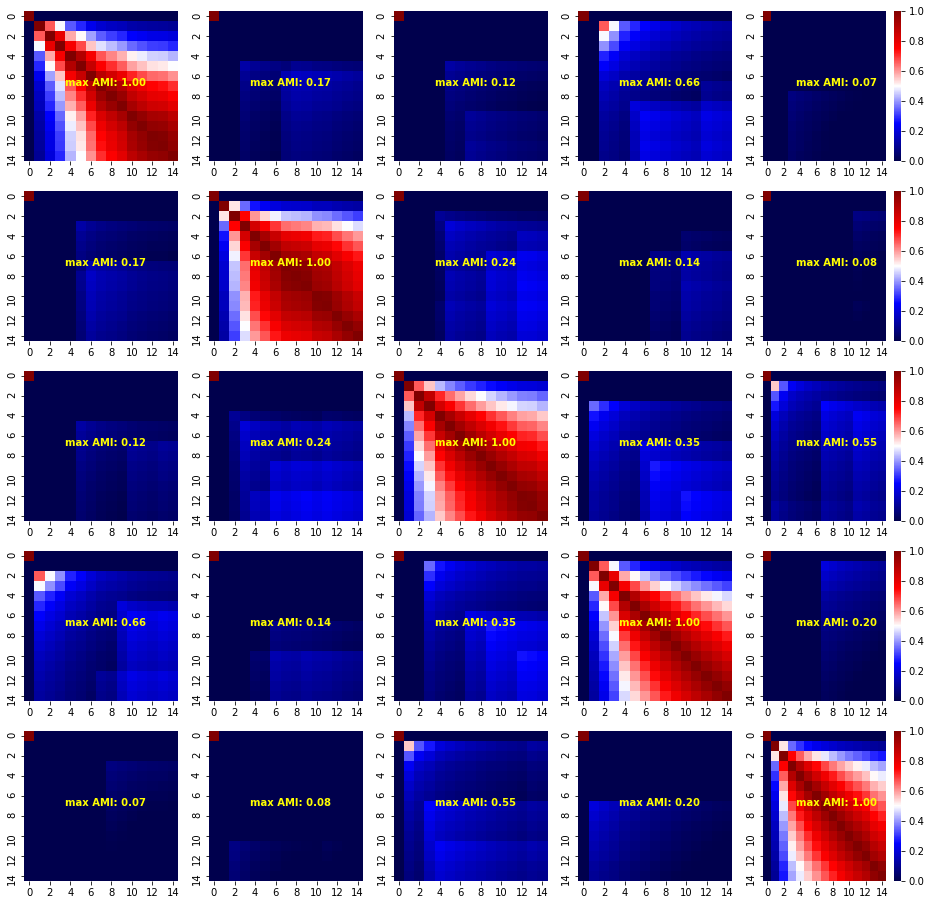

100%|██████████| 100/100 [00:49<00:00,  2.02it/s]

Final loss: 1.74010949890788


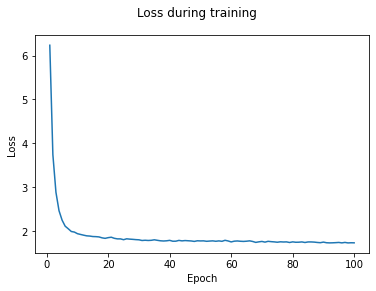

100%|██████████| 100/100 [00:49<00:00,  2.02it/s]

Final loss: 1.6966628679415074


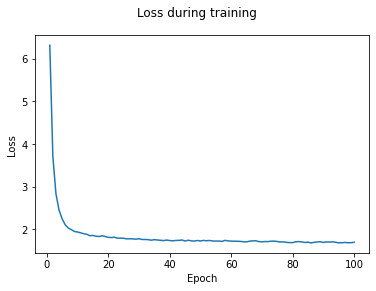

100%|██████████| 100/100 [00:49<00:00,  2.03it/s]

Final loss: 1.7137171146346302


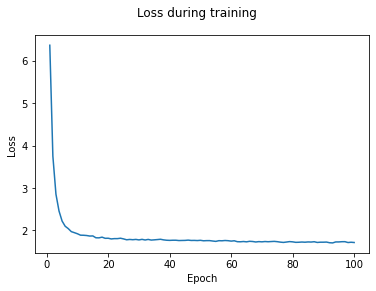

100%|██████████| 100/100 [00:49<00:00,  2.02it/s]

Final loss: 1.6677530218915242


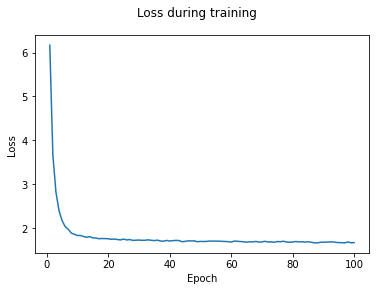

100%|██████████| 100/100 [00:49<00:00,  2.03it/s]

Final loss: 1.6658639995063222


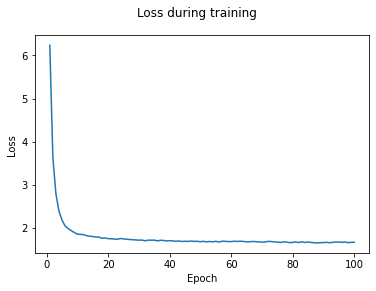

100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


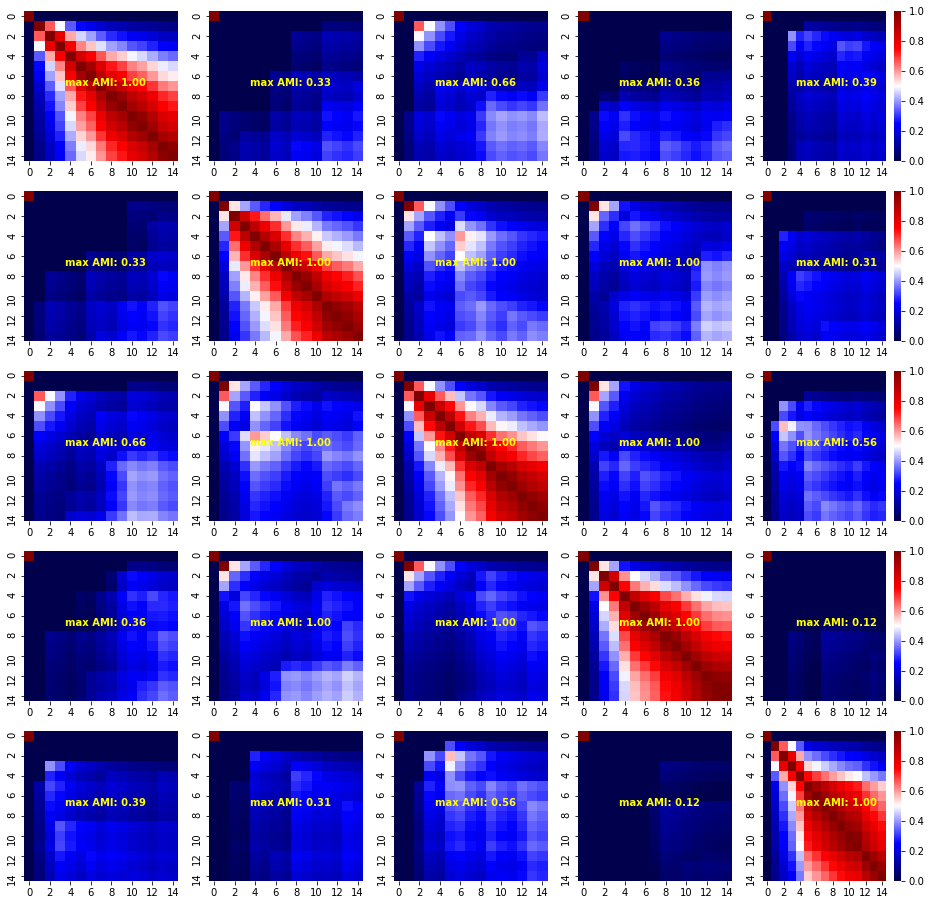

<IPython.core.display.Javascript object>

In [18]:
for latent_dim in latent_dims:
    latents_dict_n2v = get_n2v_latents_for_seed(
        graph_data,
        seeds,
        latent_dim=latent_dim,
        walk_length=50,
        context_size=5,
        walks_per_node=20,
        batch_size=4,
        num_workers=4,
        lr=0.01,
        n_epochs=100,
        plot_loss=True,
    )
    stability_amis_n2v = stability_cocluster_screen(
        latents_dict_n2v, linkage="average", affinity="euclidean"
    )
    plot_amis_matrices(seeds, stability_amis_n2v)

---

#### 3.1.2. GAE

After having assess the stability of the Node2Vec embeddings we will now run a similar analyses using a GAE model. Hereby, we will first vary the type of input features that we provide alongside with the adjacency matrix, before we also assess setups with different training objectives and different model configurations.

##### Topology-GAE

The first model does not uses any meaningful input features but is simply the identity matrix. Thus, the network should mostly focus on the graph structure. We will train the model on the task of reconstructing the adjacency matrix. Note that we do not split the data but simply aim to find a low-dimensional embedding that encodes the adjacency matrix.

 29%|██▉       | 292/1000 [00:02<00:06, 103.44it/s]


------------------------------------------------------------


 30%|███       | 304/1000 [00:03<00:07, 93.93it/s] 


------------------------------------------------------------


 28%|██▊       | 282/1000 [00:03<00:07, 92.69it/s] 


------------------------------------------------------------


 32%|███▏      | 318/1000 [00:03<00:06, 105.27it/s]


------------------------------------------------------------


 28%|██▊       | 275/1000 [00:02<00:07, 93.29it/s] 


------------------------------------------------------------


100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


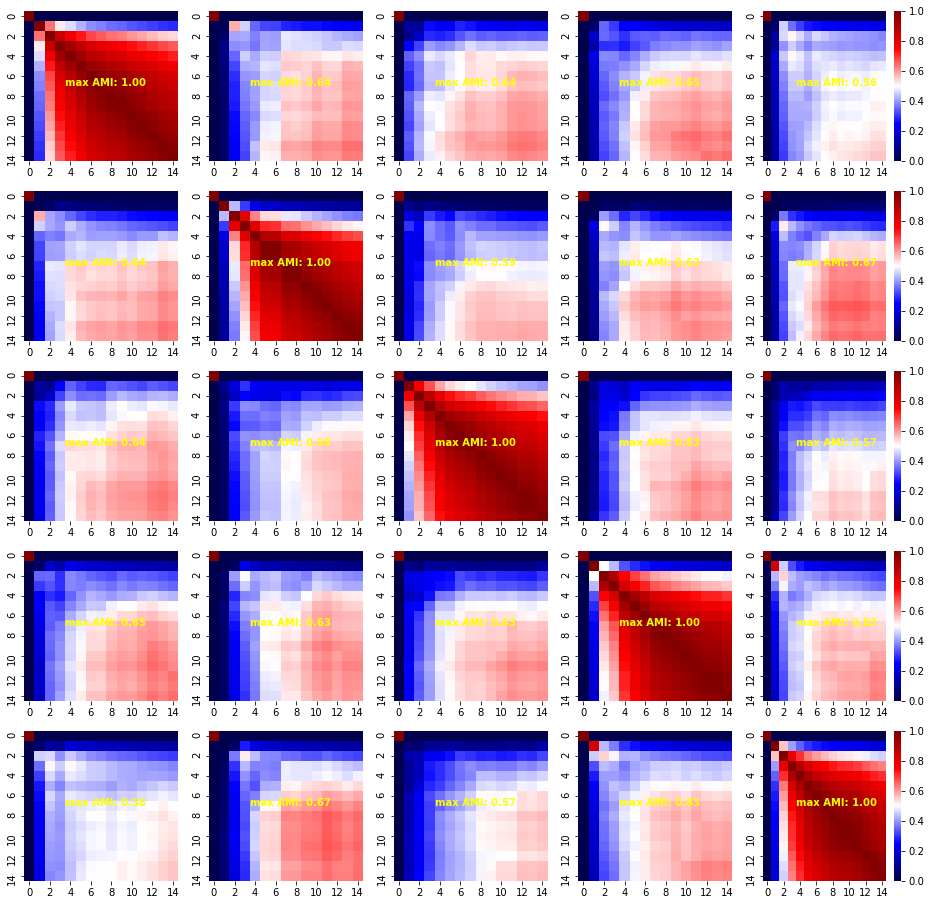

 27%|██▋       | 274/1000 [00:02<00:07, 91.34it/s] 


------------------------------------------------------------


 33%|███▎      | 328/1000 [00:03<00:07, 92.70it/s] 


------------------------------------------------------------


 26%|██▋       | 263/1000 [00:03<00:09, 81.49it/s]


------------------------------------------------------------


 28%|██▊       | 280/1000 [00:03<00:08, 89.34it/s] 


------------------------------------------------------------


 24%|██▎       | 236/1000 [00:02<00:09, 83.96it/s] 


------------------------------------------------------------


100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


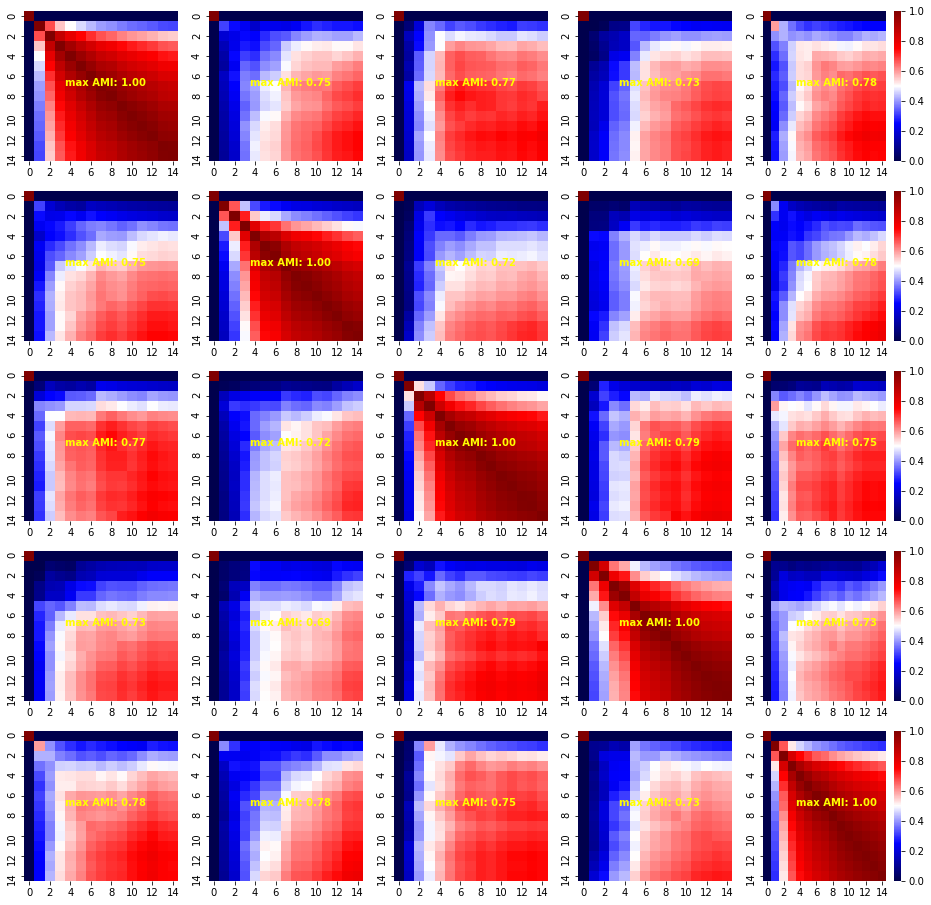

 22%|██▏       | 216/1000 [00:02<00:09, 86.64it/s]


------------------------------------------------------------


 42%|████▏     | 417/1000 [00:04<00:06, 93.34it/s] 


------------------------------------------------------------


 21%|██        | 212/1000 [00:02<00:08, 88.39it/s] 


------------------------------------------------------------


 45%|████▌     | 450/1000 [00:04<00:06, 91.11it/s] 


------------------------------------------------------------


 34%|███▍      | 343/1000 [00:03<00:07, 88.94it/s] 


------------------------------------------------------------


100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


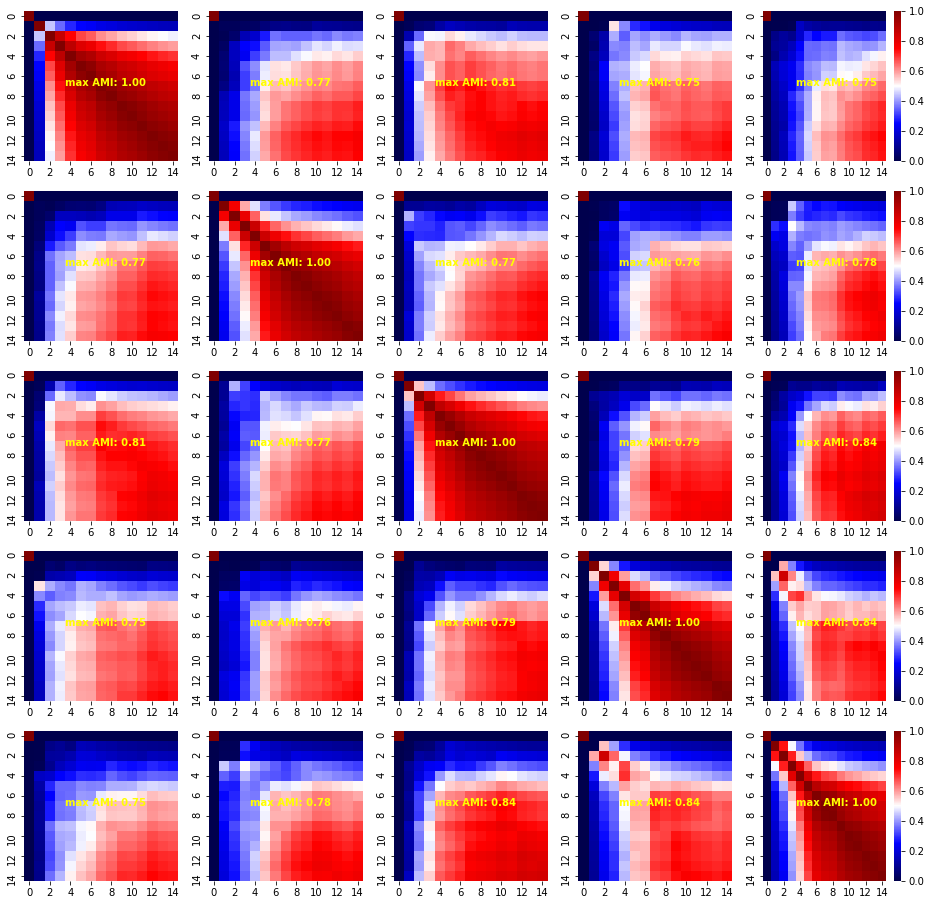

<IPython.core.display.Javascript object>

In [21]:
node_feature_key = "id"

for latent_dim in latent_dims:
    latents_dict_topogae = get_gae_latents_for_seed(
        graph_data=graph_data,
        seeds=seeds,
        node_feature_key=node_feature_key,
        input_dim=163,
        latent_dim=latent_dim,
        hidden_dim=128,
        n_epochs=1000,
        plot_loss=False,
    )
    stability_amis_topogae = stability_cocluster_screen(
        latents_dict_topogae, linkage="average", affinity="euclidean"
    )
    plot_amis_matrices(seeds, stability_amis_topogae)

We see that for the GAE trained on solely minimizing the loss of the reconstruction of the adjacency matrix shows a significant dependence of the random initialization. Interestingly, we obtain more stable embeddings for 64 latent dimensions than we obtain for 128 or 32.

---

##### Hallmark GAE

The next model is trained on a similar task but uses geneset memberships as node features, i.e. indicator variables assessing the inclusion of each node in one of the 50 Hallmark gene sets.

 35%|███▌      | 352/1000 [00:03<00:06, 94.65it/s] 


------------------------------------------------------------


 49%|████▉     | 489/1000 [00:04<00:05, 98.65it/s] 


------------------------------------------------------------


 35%|███▌      | 351/1000 [00:03<00:07, 92.67it/s] 


------------------------------------------------------------


 46%|████▌     | 462/1000 [00:04<00:05, 104.37it/s]


------------------------------------------------------------


 48%|████▊     | 475/1000 [00:04<00:05, 96.29it/s] 


------------------------------------------------------------


100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


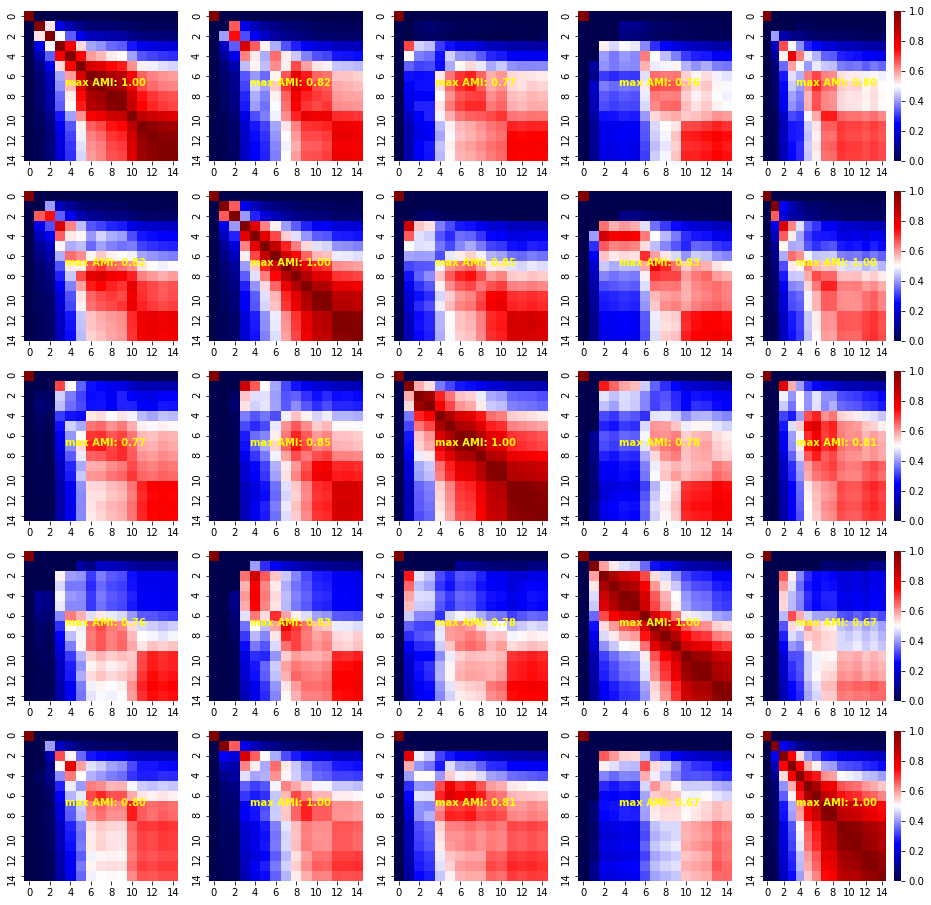

 40%|███▉      | 395/1000 [00:04<00:06, 89.75it/s] 


------------------------------------------------------------


 26%|██▋       | 265/1000 [00:03<00:08, 84.81it/s] 


------------------------------------------------------------


 37%|███▋      | 370/1000 [00:03<00:06, 93.85it/s] 


------------------------------------------------------------


 40%|███▉      | 395/1000 [00:04<00:06, 94.86it/s] 


------------------------------------------------------------


 41%|████      | 406/1000 [00:04<00:06, 93.41it/s] 


------------------------------------------------------------


100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


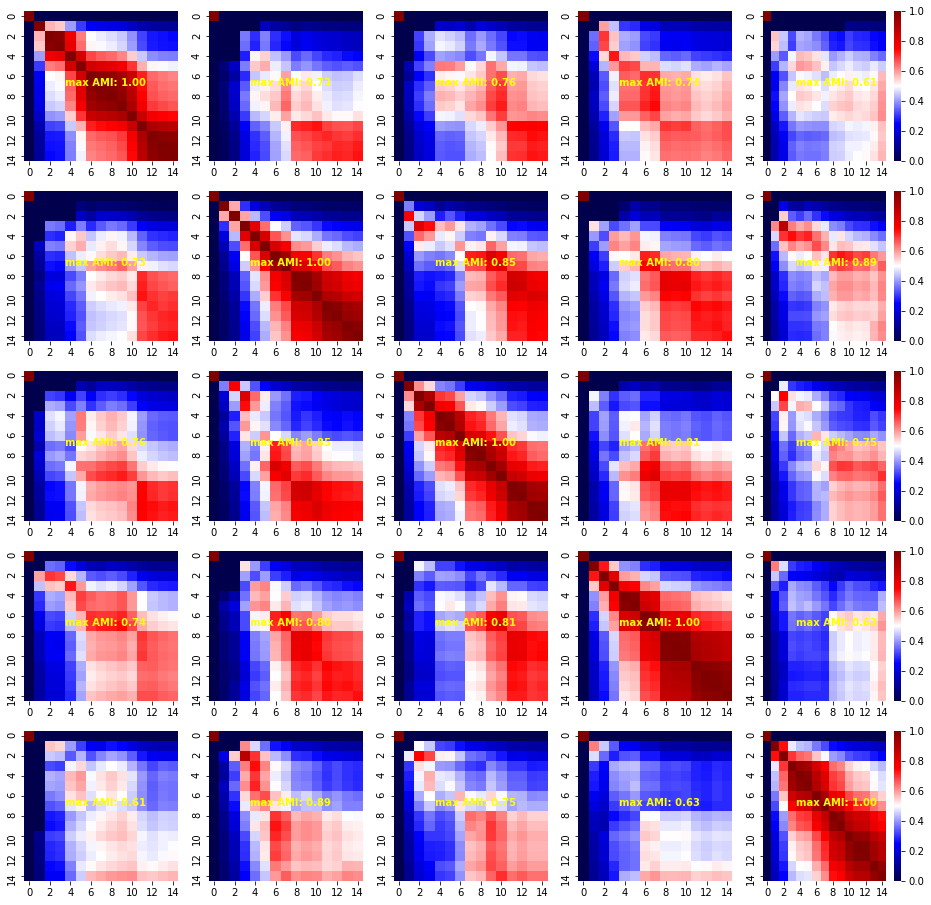

 40%|████      | 404/1000 [00:04<00:06, 95.16it/s] 


------------------------------------------------------------


 27%|██▋       | 274/1000 [00:02<00:06, 105.39it/s]


------------------------------------------------------------


 31%|███       | 312/1000 [00:03<00:07, 91.59it/s]


------------------------------------------------------------


 27%|██▋       | 271/1000 [00:03<00:08, 89.42it/s] 


------------------------------------------------------------


 37%|███▋      | 366/1000 [00:03<00:06, 98.52it/s] 


------------------------------------------------------------


100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


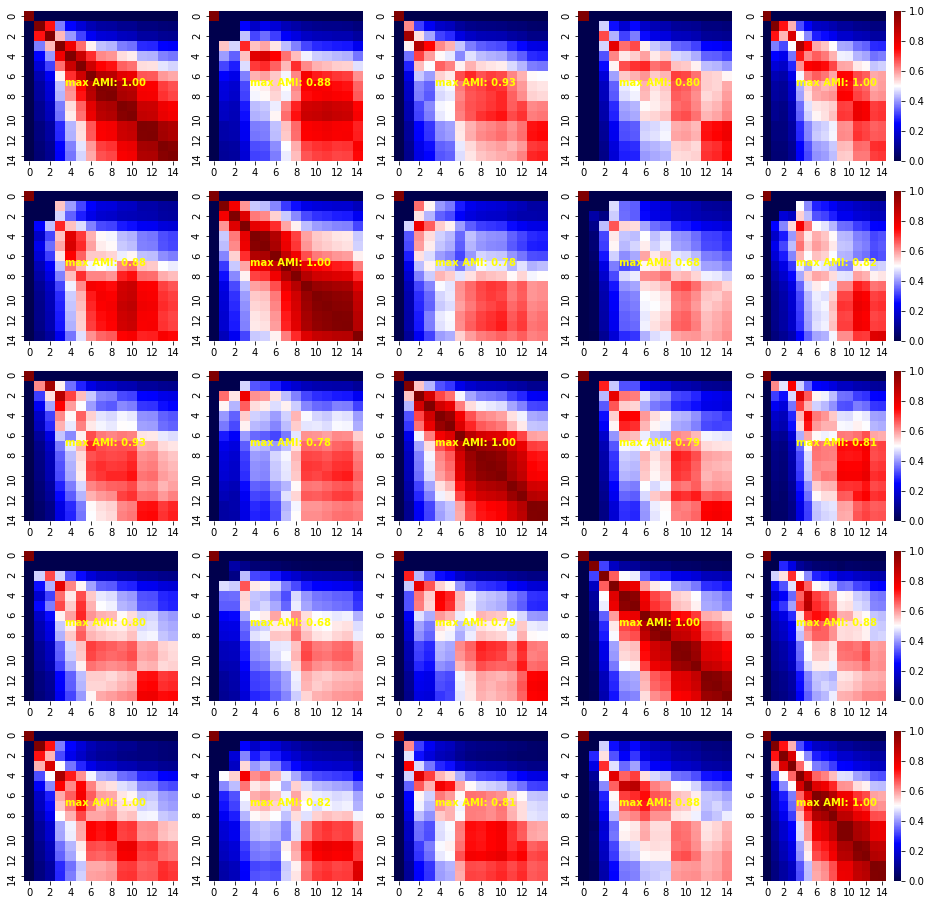

<IPython.core.display.Javascript object>

In [24]:
node_feature_key = "hallmark"
for latent_dim in latent_dims:
    latents_dict_hallgae = get_gae_latents_for_seed(
        graph_data=graph_data,
        seeds=seeds,
        node_feature_key=node_feature_key,
        input_dim=50,
        latent_dim=latent_dim,
        hidden_dim=128,
        n_epochs=1000,
        plot_loss=False,
    )
    stability_amis_hallgae = stability_cocluster_screen(
        latents_dict_hallgae, linkage="average", affinity="euclidean"
    )
    plot_amis_matrices(seeds, stability_amis_hallgae)

We find the embeddings for the Hallmark GAE to be relatively stable for different numbers of latent dimensions.

---

##### Hallmark-GEX GAE

Finally, we train an autoencoder using both the binary hallmark geneset features and the min-max-scaled gene expression data as inputs.

 82%|████████▏ | 824/1000 [00:09<00:01, 88.94it/s] 


------------------------------------------------------------


 72%|███████▏  | 723/1000 [00:07<00:02, 97.32it/s] 


------------------------------------------------------------


 80%|███████▉  | 799/1000 [00:08<00:02, 95.79it/s] 


------------------------------------------------------------


 95%|█████████▌| 951/1000 [00:09<00:00, 99.18it/s] 


------------------------------------------------------------


 58%|█████▊    | 579/1000 [00:05<00:04, 99.38it/s] 


------------------------------------------------------------


100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


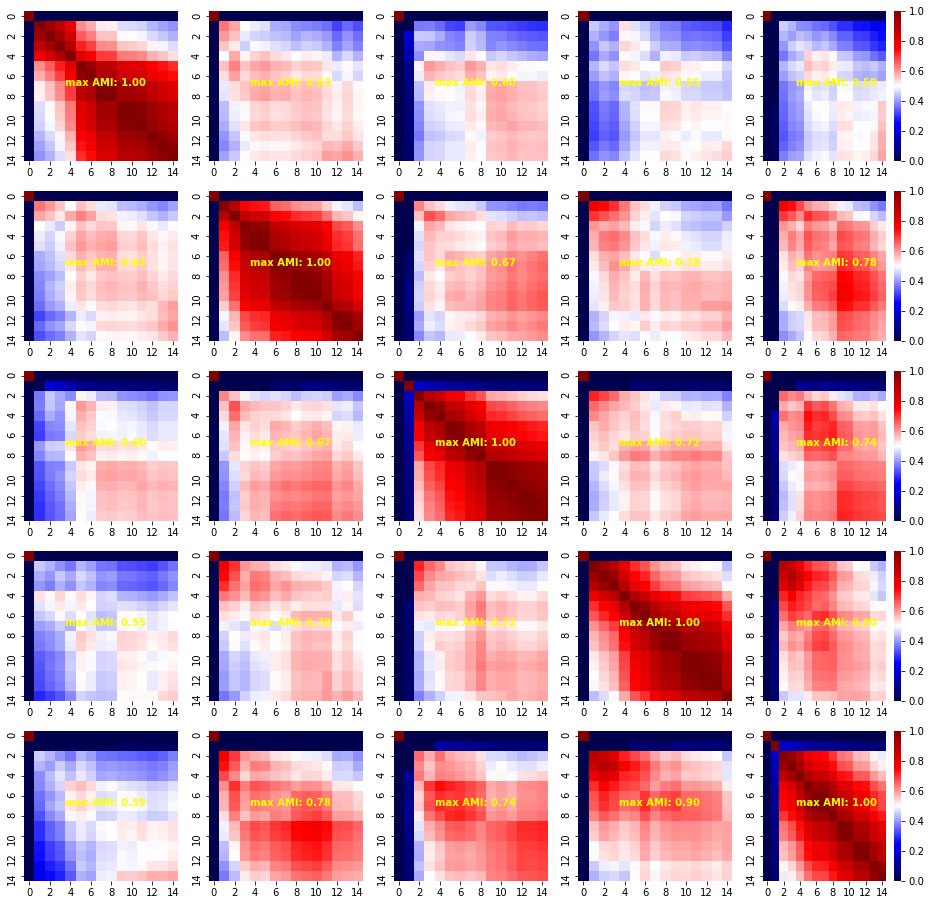

 72%|███████▏  | 720/1000 [00:08<00:03, 87.48it/s] 


------------------------------------------------------------


 62%|██████▏   | 618/1000 [00:06<00:04, 92.11it/s] 


------------------------------------------------------------


 70%|███████   | 705/1000 [00:07<00:03, 97.74it/s] 


------------------------------------------------------------


 85%|████████▍ | 847/1000 [00:08<00:01, 100.67it/s]


------------------------------------------------------------


 82%|████████▏ | 821/1000 [00:08<00:01, 96.86it/s] 


------------------------------------------------------------


100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


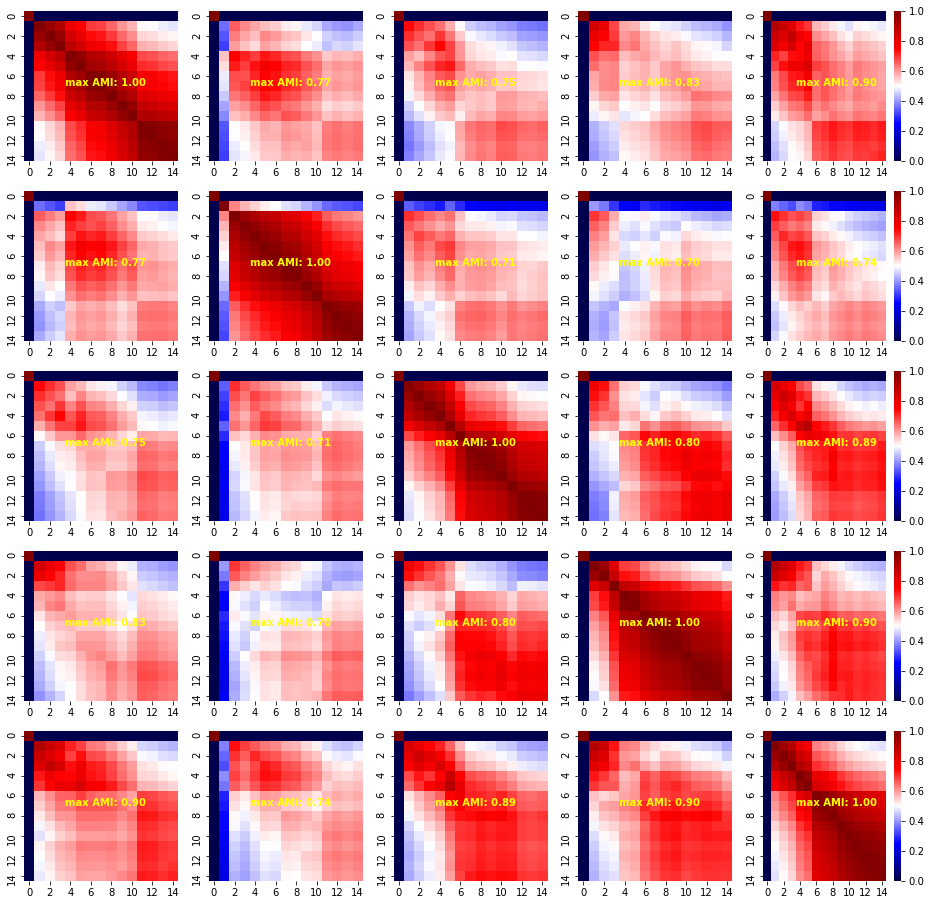

 45%|████▌     | 451/1000 [00:05<00:06, 88.39it/s] 


------------------------------------------------------------


 74%|███████▍  | 744/1000 [00:08<00:03, 84.87it/s] 


------------------------------------------------------------


 73%|███████▎  | 726/1000 [00:08<00:03, 87.93it/s] 


------------------------------------------------------------


 72%|███████▏  | 724/1000 [00:08<00:03, 89.13it/s] 


------------------------------------------------------------


 74%|███████▍  | 743/1000 [00:08<00:02, 88.33it/s] 


------------------------------------------------------------


100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


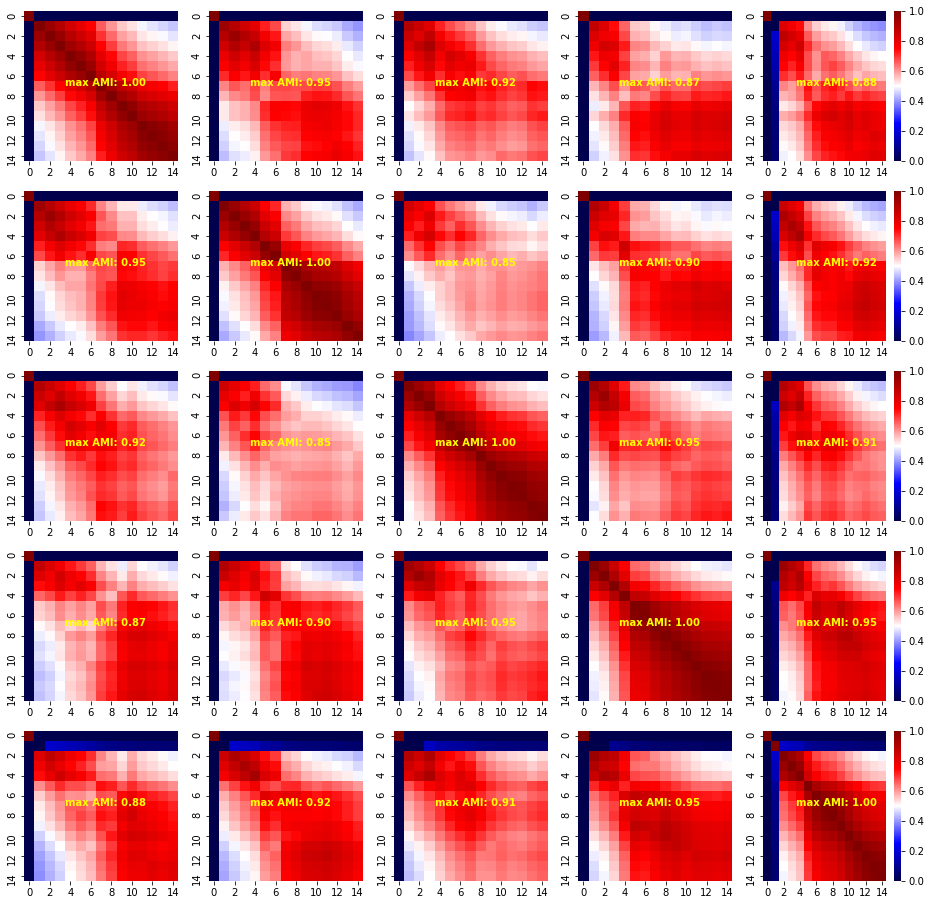

<IPython.core.display.Javascript object>

In [26]:
node_feature_key = "sc_gex_hallmark"

for latent_dim in latent_dims:
    latents_dict_hallgexgae = get_gae_latents_for_seed(
        graph_data=graph_data,
        seeds=seeds,
        node_feature_key=node_feature_key,
        input_dim=1176,
        latent_dim=latent_dim,
        hidden_dim=128,
        n_epochs=1000,
        lr=0.00001,
        plot_loss=False,
    )
    stability_amis_hallgexgae = stability_cocluster_screen(
        latents_dict_hallgexgae, linkage="average", affinity="euclidean"
    )
    plot_amis_matrices(seeds, stability_amis_hallgexgae)

We obtain fairly stable results for different choices of the size of the latent space as well.

---

##### Hallmark-GEX GAE (link prediction)

We will now reassess the previous model's stability when training it on a link-prediction task.
That is the data will also be split differently for each term.

 77%|███████▋  | 773/1000 [00:10<00:02, 77.16it/s]


------------------------------------------------------------
TEST AUC: 0.6444970414201184 	 AP: 0.6515318938451196


 51%|█████     | 512/1000 [00:06<00:06, 77.94it/s]


------------------------------------------------------------
TEST AUC: 0.6866272189349113 	 AP: 0.7101756840777635


 37%|███▋      | 373/1000 [00:05<00:08, 74.41it/s]


------------------------------------------------------------
TEST AUC: 0.787455621301775 	 AP: 0.7928070420667148


 40%|███▉      | 396/1000 [00:05<00:07, 79.08it/s]


------------------------------------------------------------
TEST AUC: 0.7317617866004962 	 AP: 0.7517831426544275


 60%|██████    | 601/1000 [00:07<00:05, 76.03it/s]


------------------------------------------------------------
TEST AUC: 0.753125 	 AP: 0.7580200671971336


100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


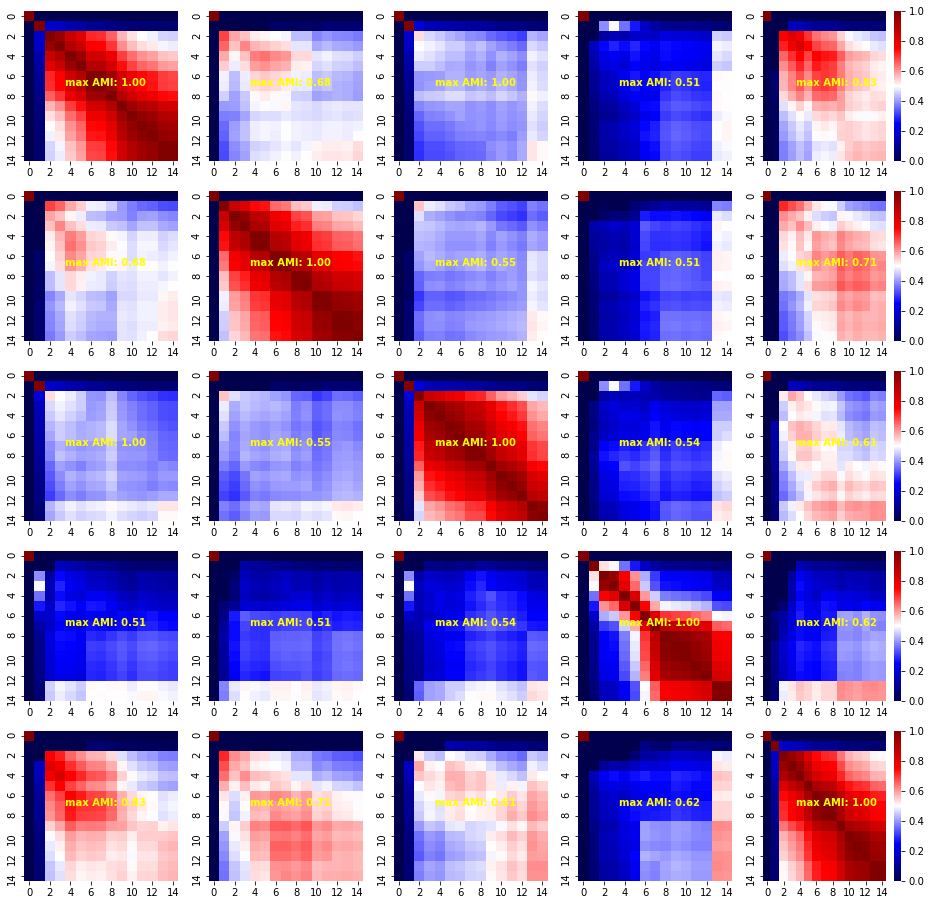

 38%|███▊      | 380/1000 [00:05<00:08, 70.62it/s]


------------------------------------------------------------
TEST AUC: 0.7441420118343195 	 AP: 0.7771050294402368


 77%|███████▋  | 766/1000 [00:10<00:03, 75.58it/s]


------------------------------------------------------------
TEST AUC: 0.796875 	 AP: 0.7918035247108213


 42%|████▏     | 418/1000 [00:05<00:07, 74.23it/s]


------------------------------------------------------------
TEST AUC: 0.739423076923077 	 AP: 0.6780536042148337


 66%|██████▌   | 660/1000 [00:08<00:04, 77.36it/s]


------------------------------------------------------------
TEST AUC: 0.741301775147929 	 AP: 0.7680018377270926


 34%|███▍      | 338/1000 [00:04<00:09, 70.61it/s]


------------------------------------------------------------
TEST AUC: 0.7750915750915751 	 AP: 0.7836743564561859


100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


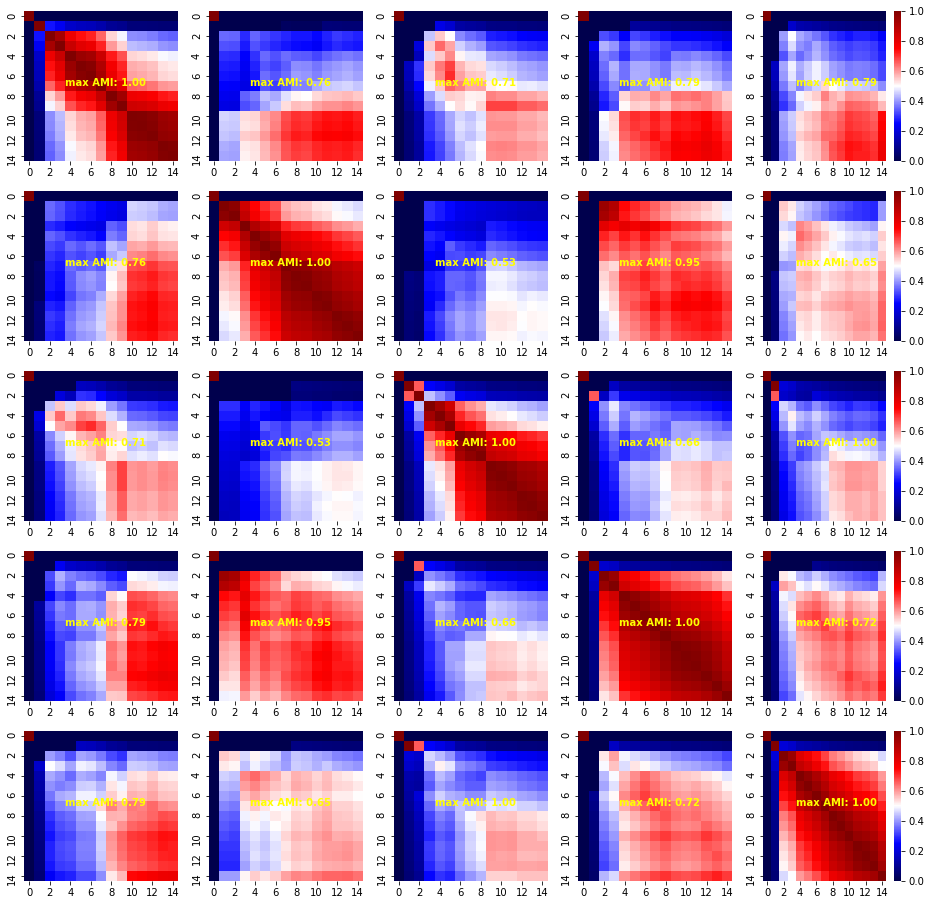

 37%|███▋      | 373/1000 [00:04<00:08, 77.34it/s]


------------------------------------------------------------
TEST AUC: 0.7441420118343195 	 AP: 0.7530115769315406


 56%|█████▌    | 560/1000 [00:07<00:06, 72.59it/s]


------------------------------------------------------------
TEST AUC: 0.7629807692307693 	 AP: 0.7663173234132776


 52%|█████▎    | 525/1000 [00:07<00:06, 73.09it/s]


------------------------------------------------------------
TEST AUC: 0.7957396449704143 	 AP: 0.7448633475008215


 57%|█████▋    | 574/1000 [00:07<00:05, 71.91it/s]


------------------------------------------------------------
TEST AUC: 0.773491124260355 	 AP: 0.7906432171640704


 39%|███▉      | 392/1000 [00:05<00:08, 73.05it/s]


------------------------------------------------------------
TEST AUC: 0.821301775147929 	 AP: 0.8239043891422388


100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


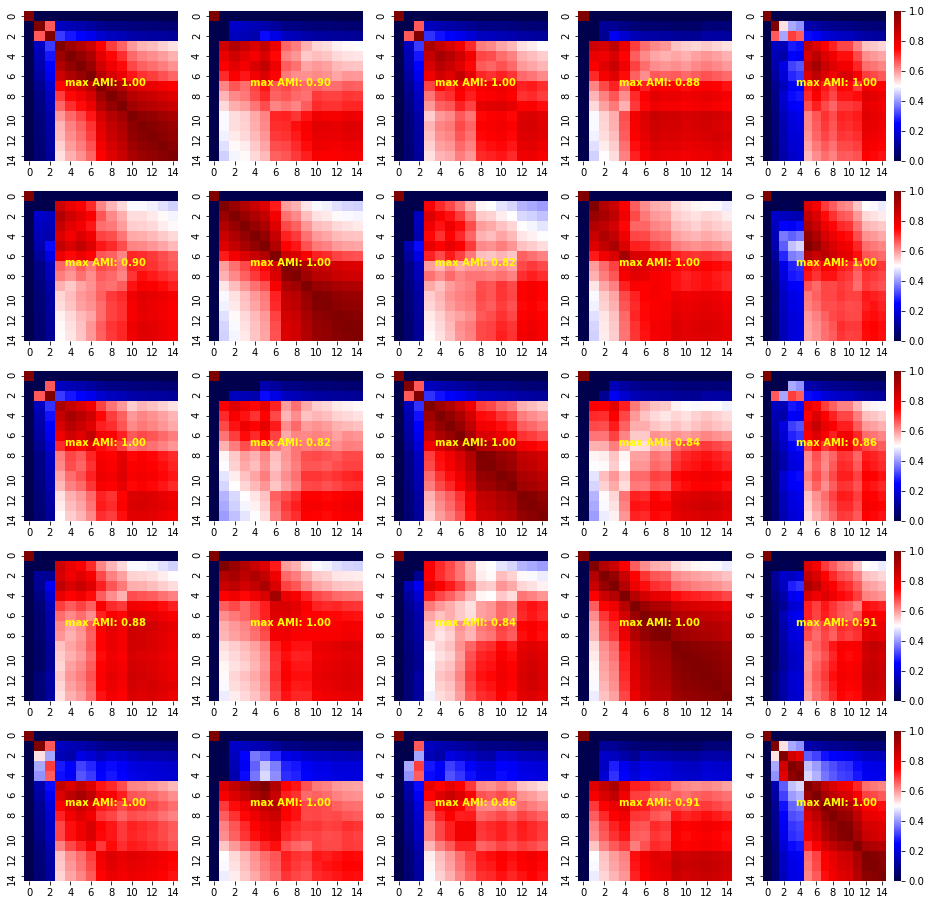

<IPython.core.display.Javascript object>

In [27]:
node_feature_key = "sc_gex_hallmark"
for latent_dim in latent_dims:
    latents_dict_hallgexgae_lp = get_gae_latents_for_seed(
        graph_data=graph_data,
        seeds=seeds,
        node_feature_key=node_feature_key,
        input_dim=1176,
        latent_dim=latent_dim,
        hidden_dim=128,
        n_epochs=1000,
        lr=0.00001,
        link_pred=True,
        plot_loss=False,
    )
    stability_amis_hallgexgae_lp = stability_cocluster_screen(
        latents_dict_hallgexgae_lp, linkage="average", affinity="euclidean"
    )
    plot_amis_matrices(seeds, stability_amis_hallgexgae_lp)

---

##### Hallmark-GEX GAE (adjacency & feature reconstruction)

Next, we keep the previous model setup but train it on the task of feature reconstruction and the reconstruction of the adjacency matrix without any training-validation or test split of the data.

Latent dim: 32


 57%|█████▋    | 571/1000 [00:10<00:07, 56.86it/s]


------------------------------------------------------------


 38%|███▊      | 376/1000 [00:06<00:10, 57.43it/s]


------------------------------------------------------------


 60%|█████▉    | 596/1000 [00:10<00:07, 56.32it/s]


------------------------------------------------------------


 74%|███████▍  | 739/1000 [00:12<00:04, 57.92it/s]


------------------------------------------------------------


 33%|███▎      | 329/1000 [00:05<00:11, 57.56it/s]


------------------------------------------------------------


100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


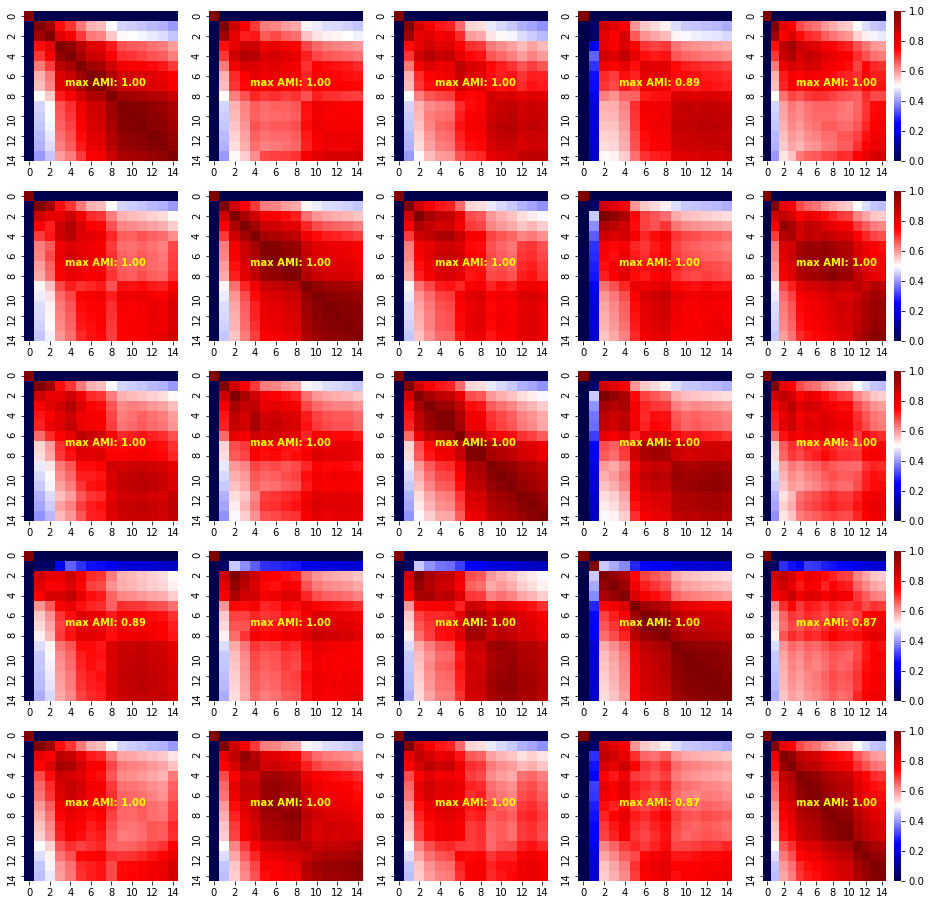

Latent dim: 64


 65%|██████▍   | 648/1000 [00:10<00:05, 58.91it/s]


------------------------------------------------------------


 65%|██████▍   | 646/1000 [00:11<00:06, 58.14it/s]


------------------------------------------------------------


 73%|███████▎  | 726/1000 [00:12<00:04, 56.95it/s]


------------------------------------------------------------


 54%|█████▍    | 542/1000 [00:09<00:07, 58.14it/s]


------------------------------------------------------------


 59%|█████▉    | 593/1000 [00:10<00:07, 57.43it/s]


------------------------------------------------------------


100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


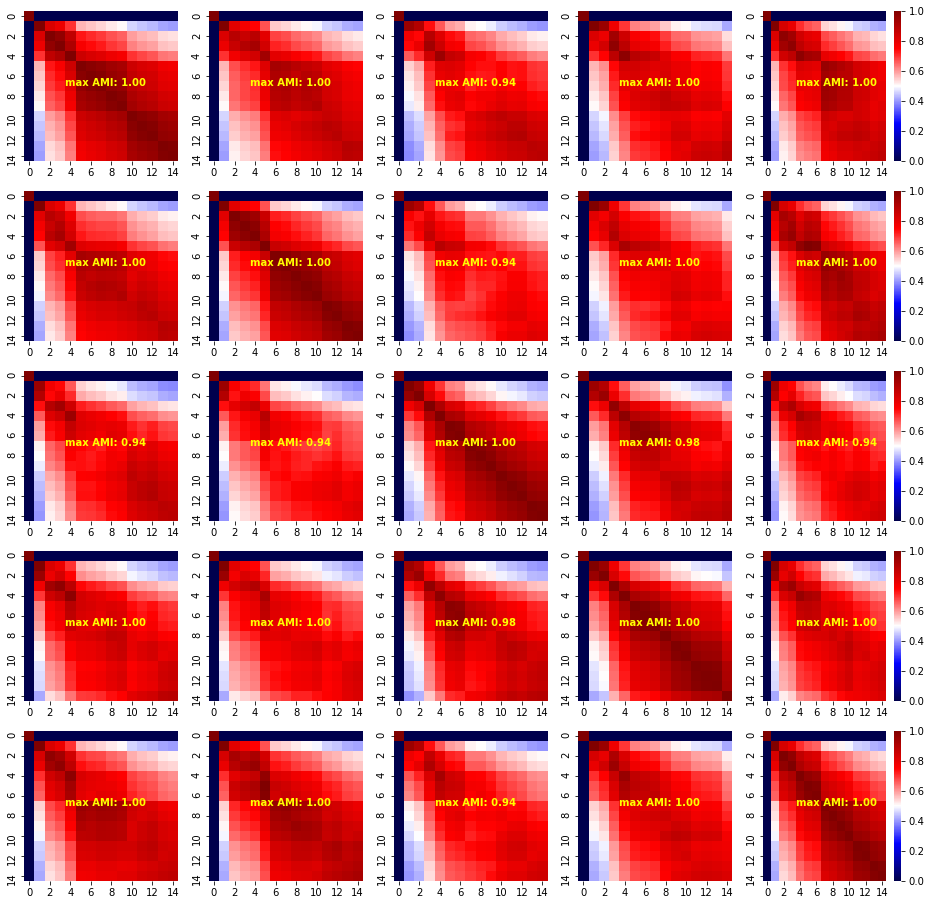

Latent dim: 128


 37%|███▋      | 368/1000 [00:06<00:11, 57.07it/s]


------------------------------------------------------------


 79%|███████▉  | 788/1000 [00:13<00:03, 56.58it/s]


------------------------------------------------------------


 45%|████▌     | 451/1000 [00:08<00:09, 55.24it/s]


------------------------------------------------------------


 64%|██████▍   | 642/1000 [00:11<00:06, 54.94it/s]


------------------------------------------------------------


 43%|████▎     | 430/1000 [00:07<00:10, 56.37it/s]


------------------------------------------------------------


100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


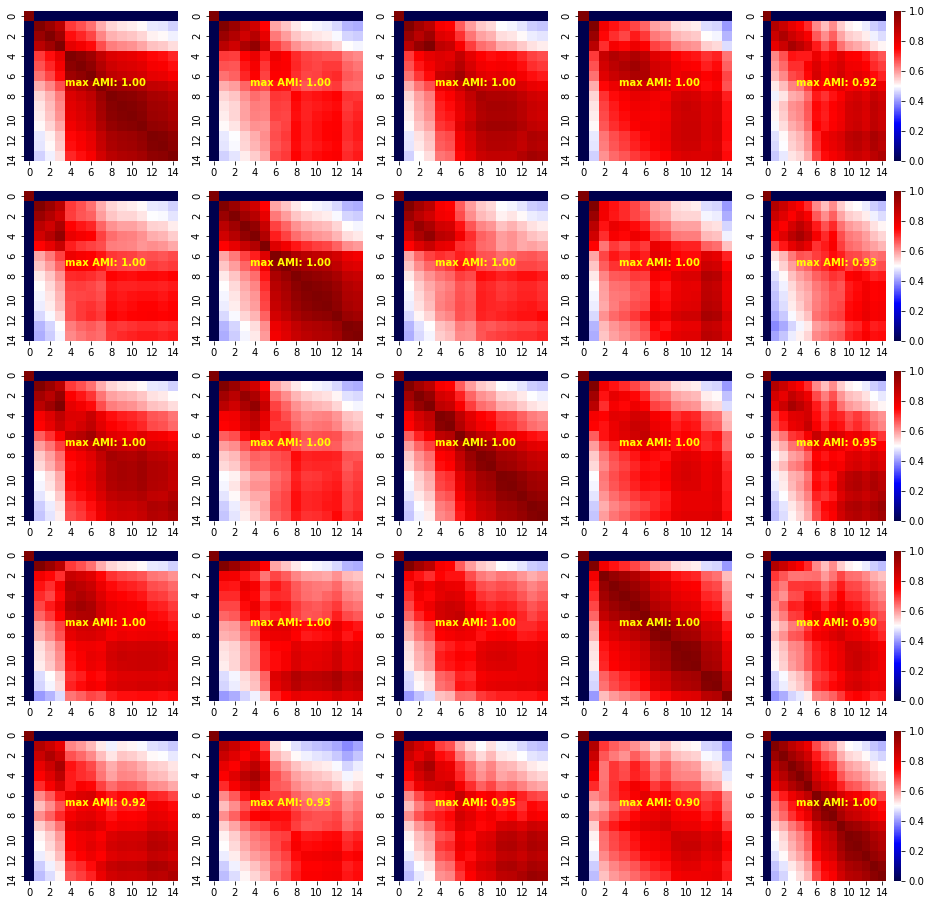

<IPython.core.display.Javascript object>

In [28]:
node_feature_key = "sc_gex_hallmark"

for latent_dim in latent_dims:
    print("Latent dim: {}".format(latent_dim))
    latents_dict_hallgexgae_feat = get_gae_latents_for_seed(
        graph_data=graph_data,
        seeds=seeds,
        node_feature_key=node_feature_key,
        input_dim=1176,
        latent_dim=latent_dim,
        hidden_dim=128,
        n_epochs=1000,
        lr=0.00005,
        link_pred=False,
        reconstruct_features=True,
        feature_decoder_params={
            "latent_dim": latent_dim,
            "output_dim": 1176,
            "hidden_dims": [128, 256, 512],
        },
        feat_loss=torch.nn.MSELoss(),
        alpha=1,
        beta=1,
        plot_loss=False,
    )
    stability_amis_hallgexgae_feat = stability_cocluster_screen(
        latents_dict_hallgexgae_feat, linkage="average", affinity="euclidean"
    )
    plot_amis_matrices(seeds, stability_amis_hallgexgae_feat)

We find that adding the reconstruction loss as an additional supervisory signal seems to improve the stability of the inferred embeddings. As for all GAE variants we see more stable solutions for the largest embedding dimension considered in the study 128.

---

##### Hallmark-GEX-GAE ( only feature reconstruction)

The final setup is training the same model as above but only on the task of feature reconstruction, i.e. assigning zero-loss for the reconstruction of the adjacency matrix.

Latent dim: 32


 60%|█████▉    | 599/1000 [00:11<00:07, 54.26it/s]


------------------------------------------------------------


 56%|█████▌    | 560/1000 [00:10<00:07, 55.04it/s]


------------------------------------------------------------


 53%|█████▎    | 527/1000 [00:09<00:08, 54.69it/s]


------------------------------------------------------------


 51%|█████▏    | 513/1000 [00:09<00:08, 55.32it/s]


------------------------------------------------------------


 64%|██████▍   | 642/1000 [00:11<00:06, 54.24it/s]


------------------------------------------------------------


100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


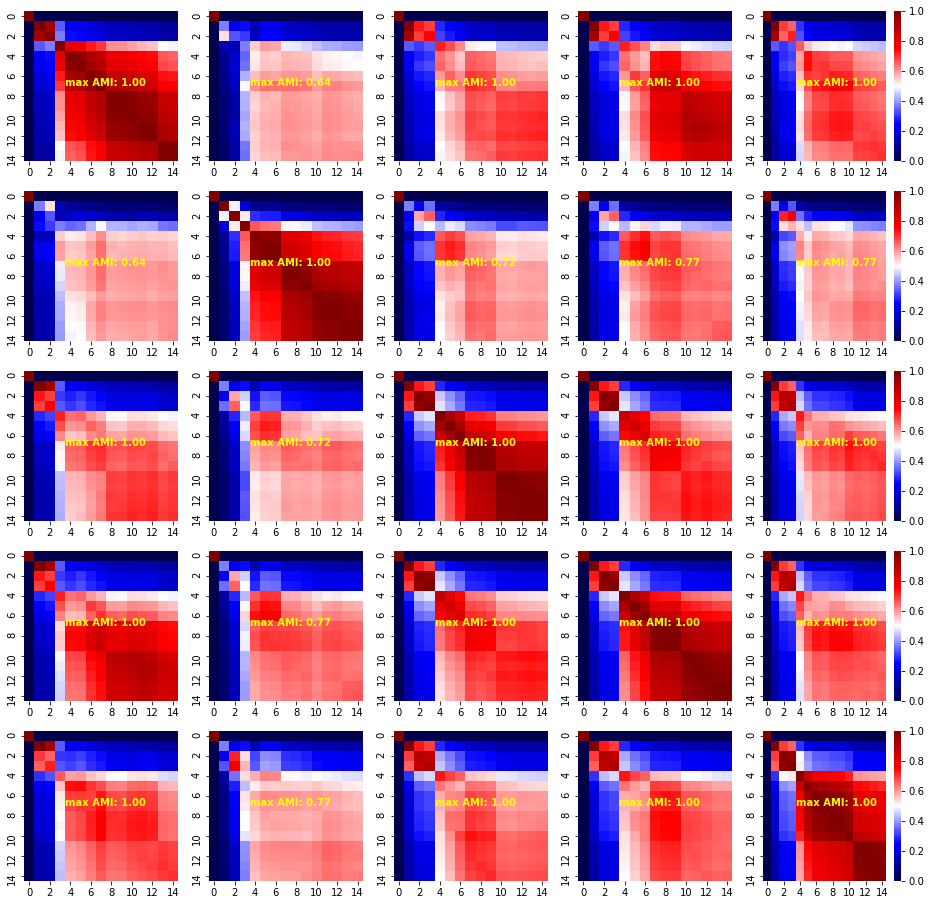

Latent dim: 64


 63%|██████▎   | 633/1000 [00:12<00:06, 52.59it/s]


------------------------------------------------------------


 75%|███████▌  | 750/1000 [00:12<00:04, 58.04it/s]


------------------------------------------------------------


 57%|█████▋    | 566/1000 [00:10<00:07, 55.13it/s]


------------------------------------------------------------


 54%|█████▍    | 539/1000 [00:09<00:08, 56.90it/s]


------------------------------------------------------------


 55%|█████▍    | 546/1000 [00:10<00:08, 53.56it/s]


------------------------------------------------------------


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


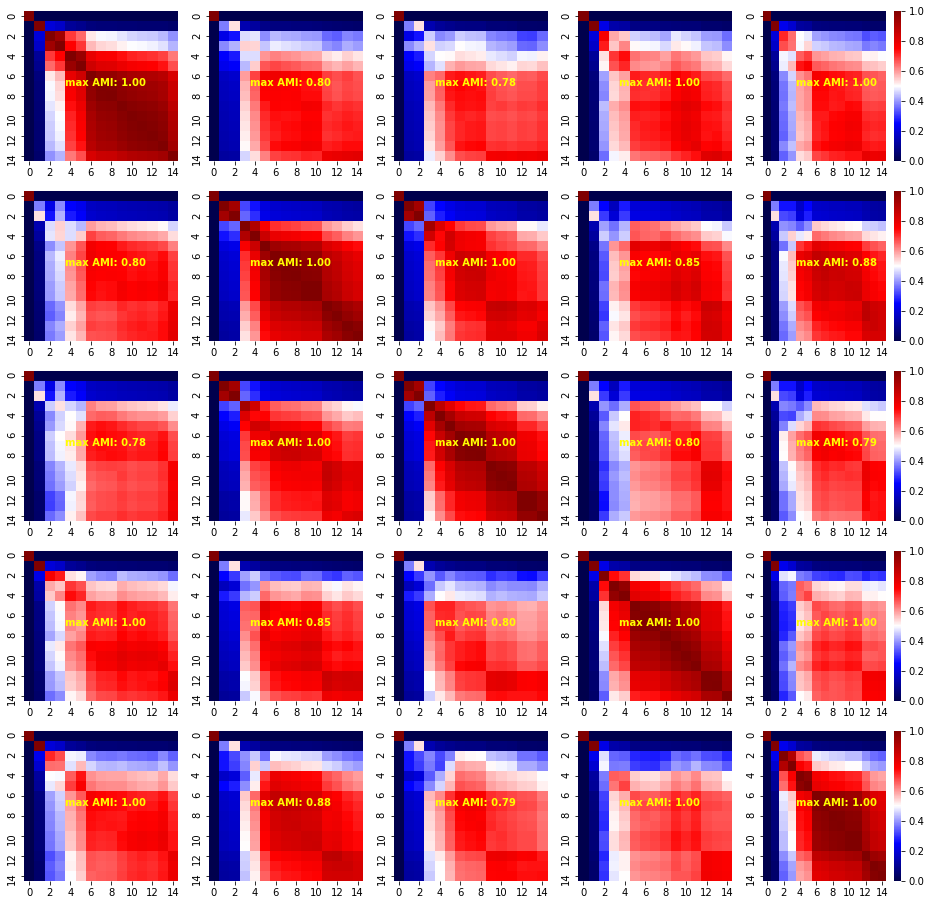

Latent dim: 128


 68%|██████▊   | 682/1000 [00:12<00:06, 52.62it/s]


------------------------------------------------------------


 67%|██████▋   | 674/1000 [00:12<00:06, 53.12it/s]


------------------------------------------------------------


 46%|████▌     | 458/1000 [00:08<00:10, 51.13it/s]


------------------------------------------------------------


 60%|██████    | 602/1000 [00:11<00:07, 54.57it/s]


------------------------------------------------------------


 73%|███████▎  | 731/1000 [00:14<00:05, 51.30it/s]


------------------------------------------------------------


100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


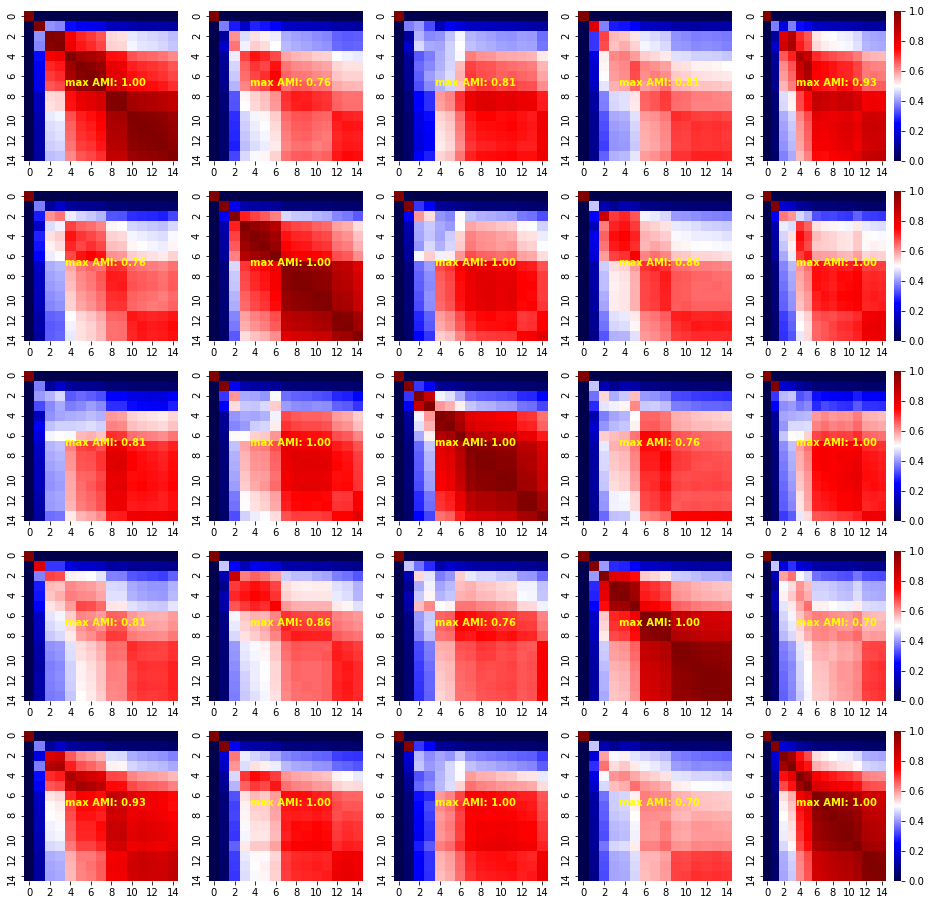

<IPython.core.display.Javascript object>

In [29]:
node_feature_key = "sc_gex_hallmark"

for latent_dim in latent_dims:
    print("Latent dim: {}".format(latent_dim))
    latents_dict_hallgexgae_feat_only = get_gae_latents_for_seed(
        graph_data=graph_data,
        seeds=seeds,
        node_feature_key=node_feature_key,
        input_dim=1176,
        latent_dim=latent_dim,
        hidden_dim=128,
        n_epochs=1000,
        lr=0.0005,
        link_pred=False,
        reconstruct_features=True,
        feature_decoder_params={
            "latent_dim": latent_dim,
            "output_dim": 1176,
            "hidden_dims": [128, 256, 512, 1024],
        },
        feat_loss=torch.nn.MSELoss(),
        alpha=0,
        beta=1,
        plot_loss=False,
    )
    stability_amis_hallgexgae_feat_only = stability_cocluster_screen(
        latents_dict_hallgexgae_feat_only, linkage="average", affinity="euclidean"
    )
    plot_amis_matrices(seeds, stability_amis_hallgexgae_feat_only)

Compared to the solution that also penalizes the mismatch of the reconstructed adjacency matrix, we see that the embeddings are more dissimilar while still highly stable in general. That is especially for a small number of clusters we often see lower adjusted mutual information scores. As we increase the dimensionality those become more stable. However at a certain point the curse of dimensionality yields to less stable cluster solutions again.

---


### 3.2. Comparison of the inferred latent spaces

We will now compare the inferred latent spaces from the different model setups introduced in the previous section. To this end, we will again assess the co-clustering of the respective models. However, this time we will only consider one random initialization for each model. We will use 128 latent dimensions for the GAE models and 32 latent dimensions for the Node2Vec model as we previously have seen that these provide the most stable results for the respective models. 

In [37]:
seed = 1234

# Since the last configuration was an embedding space of size 128, we can simply use the
# precomputed latents for those models
comp_latents_dict = {
    "gae_id": latents_dict_topogae[seed],
    "gae_hallmark": latents_dict_hallgae[seed],
    "gae_hallgex": latents_dict_hallgexgae[seed],
    "gae_hallgex_lp": latents_dict_hallgexgae_lp[seed],
    "gae_hallgex_feat": latents_dict_hallgexgae_feat[seed],
    "gae_hallgex_feat_only": latents_dict_hallgexgae_feat_only[seed],
}

# We quickly recompute the corresponding embeddings for the Node2Vec model
latents_dict_n2v = get_n2v_latents_for_seed(
    graph_data,
    [seed],
    latent_dim=32,
    walk_length=50,
    context_size=5,
    walks_per_node=20,
    batch_size=4,
    num_workers=4,
    lr=0.01,
    n_epochs=100,
    plot_loss=False,
)
comp_latents_dict["n2v"] = latents_dict_n2v[seed]

100%|██████████| 100/100 [00:51<00:00,  1.93it/s]

Final loss: 0.9565745039684016


<IPython.core.display.Javascript object>

100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


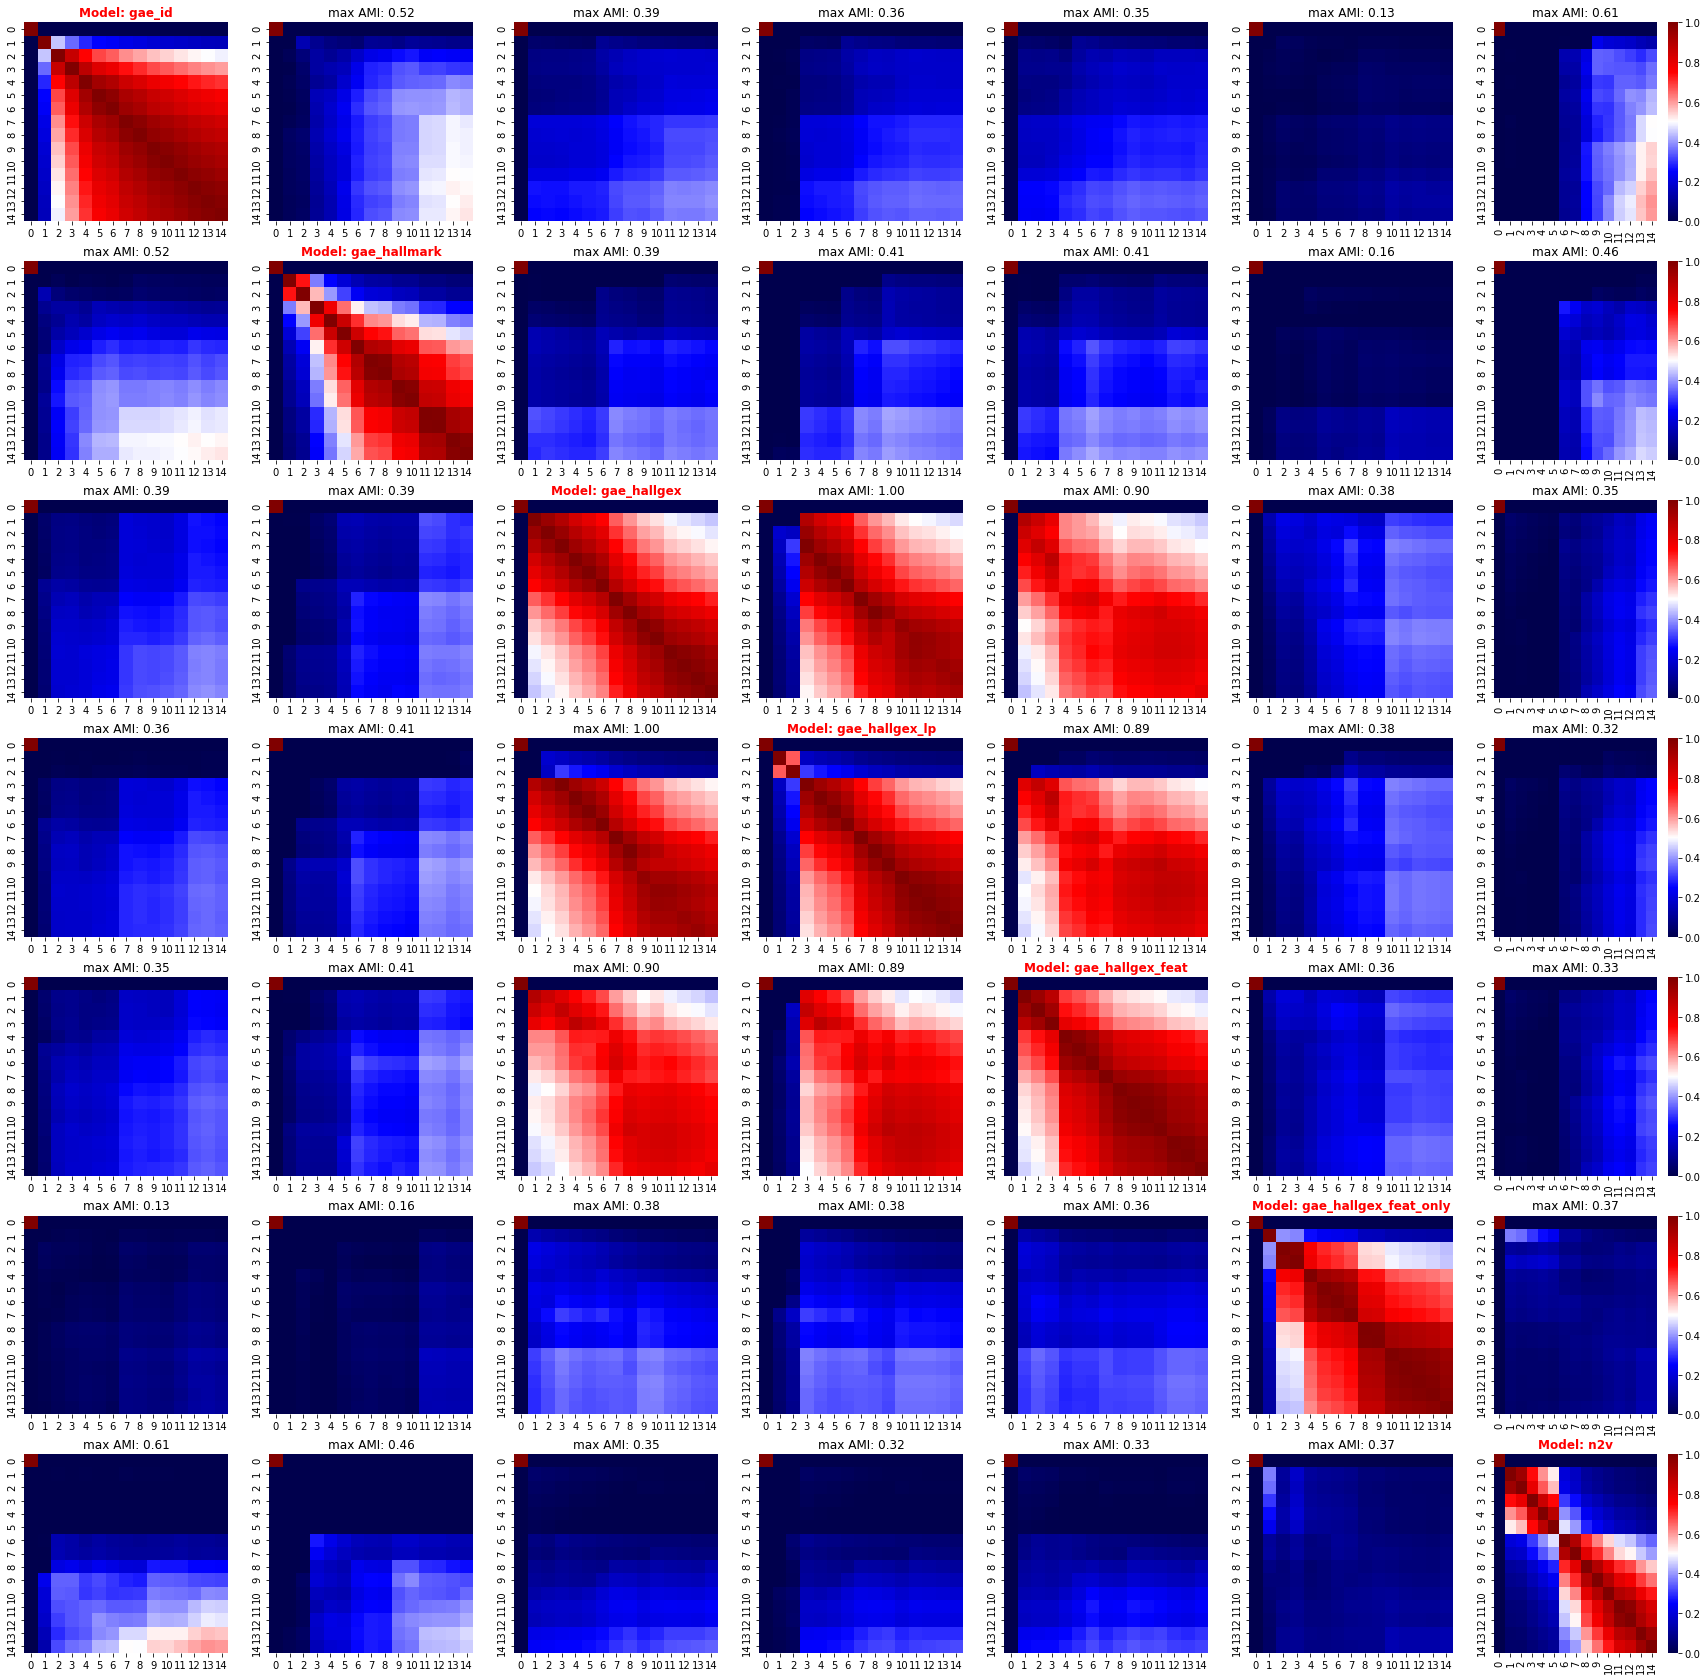

<IPython.core.display.Javascript object>

In [54]:
stability_amis_comparison = stability_cocluster_screen(
    comp_latents_dict, linkage="average", affinity="euclidean"
)
plot_amis_matrices(list(comp_latents_dict.keys()), stability_amis_comparison)

The plot above suggests that only the models that use the sc-RNAseq data as input features yield comparable latent spaces. The other modelsshow only limited co-clustering especially for a low-number of clusters. Thus, we suggest to use the embeddings obtained from the GAE using the Hallmark geneset membership and the single-cell gene expression data as input trained without a data split but on the task of the reconstruction of both the feature matrix and the adjacency matrix. Note that this solution also yielded us the most stable embeddings as seen in the previous analyses.

---

### 3.3. Analyses of the inferred node embeddings

As discussed earlier, we will select the embeddings obtained from the previously described model as the final embeddings of the nodes in our network. We now will visualize and analyze the node embeddings with respect to their clustering to validate that e.g. genes which are known to function together co-cluster in the embedding space.

#### Visualization of the inferred latent space

In [56]:
latents = comp_latents_dict["gae_hallgex_feat"]

<IPython.core.display.Javascript object>

In [57]:
node_names = getattr(graph_data, "name")
cc_memberships = getattr(graph_data, "cell_cycle")
co_memberships = getattr(graph_data, "chromatin_org")
dr_memberships = getattr(graph_data, "dna_repair")
cd_memberships = getattr(graph_data, "cell_death")
cr_memberships = getattr(graph_data, "cytoskeleton_org")
tf_memberships = getattr(graph_data, "tf")
st_memberships = getattr(graph_data, "spec_target")

<IPython.core.display.Javascript object>

In [99]:
latents = pd.DataFrame(latents, index=node_names)

<IPython.core.display.Javascript object>

In [72]:
norm_zs = StandardScaler().fit_transform(latents)
embs = TSNE(random_state=1234, perplexity=30).fit_transform(norm_zs)
embs = pd.DataFrame(embs, columns=["tsne-0", "tsne-1"], index=node_names)
embs["cell_cycle"] = cc_memberships.cpu().numpy()
embs["chromatin_org"] = co_memberships.cpu().numpy()
embs["dna_repair"] = dr_memberships.cpu().numpy()
embs["cell_death"] = cd_memberships.cpu().numpy()
embs["cytoskeleton_org"] = cr_memberships.cpu().numpy()
embs["tfs"] = tf_memberships.cpu().numpy()
embs["spec_target"] = st_memberships.cpu().numpy()

<IPython.core.display.Javascript object>

In [59]:
def label_point(x, y, val, ax):
    for i in range(len(x)):
        ax.text(x[i] + 0.02, y[i], val[i], {"size": 10})

<IPython.core.display.Javascript object>

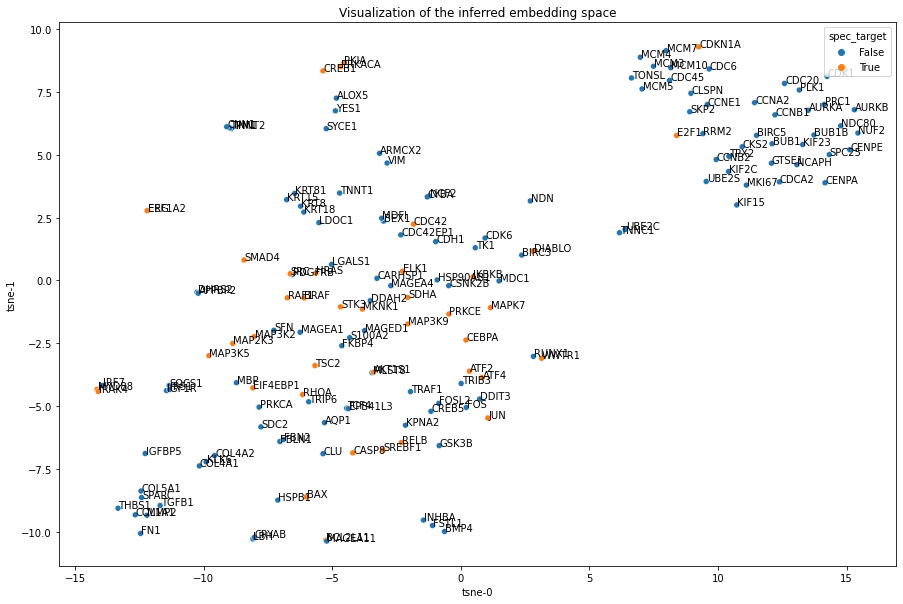

<IPython.core.display.Javascript object>

In [78]:
fig, ax = plt.subplots(figsize=[15, 10])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="spec_target"
)
label_point(
    np.array(embs.loc[:, "tsne-0"]),
    np.array(embs.loc[:, "tsne-1"]),
    np.array(embs.index).astype("str"),
    ax=ax,
)
ax.set_title("Visualization of the inferred embedding space")
plt.show()

#### Clustering of the embedding space

We will now perform a cluster analyses using hierarchical clustering based on the euclidean distances of the individual node embeddings and average linkage.

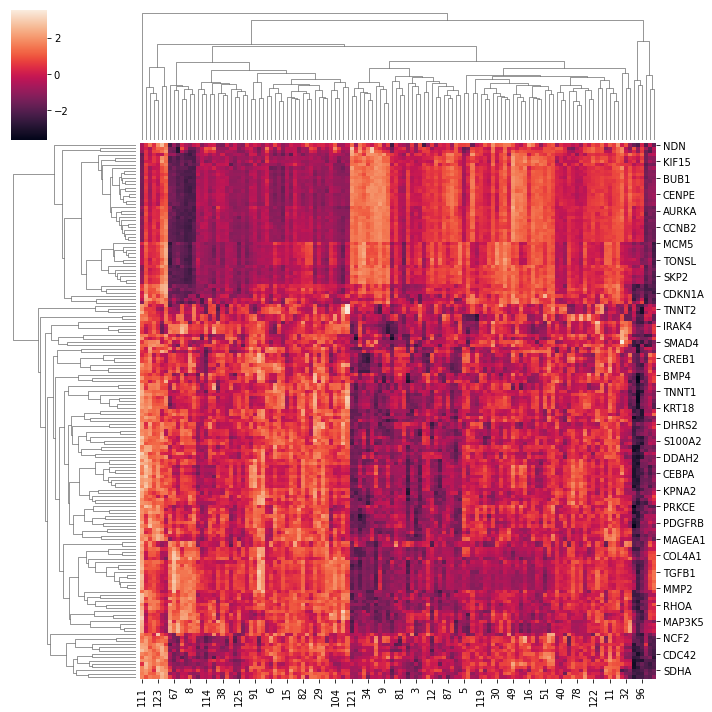

<IPython.core.display.Javascript object>

In [100]:
ax = sns.clustermap(
    latents,
    figsize=[10, 10],
    z_score=0,
    metric="euclidean",
    method="average",
)

To identify the optimal cut-off for the dendogram, we will use the stability screen method implemented in the R package `pvclust`.

In [103]:
latents.to_csv("../../../data/ppi/embedding/node_embeddings.csv", index=True)

<IPython.core.display.Javascript object>

#### Model training

As a first setup we will use no specific node features to learn the graph embedding but simply provide the identity matrix node features. We aim to embed each node in a 128 dimensional space and follow the example by Kipf & Welling and set the hidden dimensionality to two times the embedding size.

In [ ]:
node_feature_key = "hallmark"
gae = GAE(GCNEncoder(in_channels=50, hidden_dim=128, out_channels=64))
gae

The GAE consists of two-layer graph-convolutional encoder that maps the node embedding from 50-512-128 dimensions. That is the latent space will be given by a euclidean 64 dimensional space. We apply a ReLU activation for nonlinearity after the first GCNConv layer.
The decoder is simply an innerproduct decoder that takes the sigmoid of the inner product of the latent embeddings for two nodes in order to compute a probabilistic adjacency matrix.

The model is trained and shows a validation and testing AUC around 0.93 and similar AP for the link prediction based on the reconstructed adjacency matrix.

In [ ]:
# inizialize the optimizer
optimizer = torch.optim.Adam(gae.parameters(), lr=0.0001)

In [ ]:
gae, loss_hist, best_epoch = train_gae(
    model=gae,
    data_dict=data_dict,
    node_feature_key=node_feature_key,
    optimizer=optimizer,
    n_epochs=1000,
    early_stopping=50,
)

#### Visualization of the embeddings

After the training, we will use the trained model to compute the node embeddings.

In [ ]:
graph_data = graph_data.to(gae.device)
inputs = getattr(graph_data, node_feature_key).float()
node_names = getattr(graph_data, "name")
cc_memberships = getattr(graph_data, "cell_cycle")
co_memberships = getattr(graph_data, "chromatin_org")
dr_memberships = getattr(graph_data, "dna_repair")
cd_memberships = getattr(graph_data, "cell_death")
cr_memberships = getattr(graph_data, "cytoskeleton_org")
tf_memberships = getattr(graph_data, "tf")
st_memberships = getattr(graph_data, "spec_target")

In [ ]:
gae.eval()
latents = gae.encode(inputs, graph_data.edge_index)
latents = latents.detach().cpu().numpy()

In [ ]:
norm_zs = StandardScaler().fit_transform(latents)
embs = TSNE(random_state=1234).fit_transform(norm_zs)
embs = pd.DataFrame(embs, columns=["tsne-0", "tsne-1"], index=node_names)
embs["cell_cycle"] = cc_memberships.cpu().numpy()
embs["chromatin_org"] = co_memberships.cpu().numpy()
embs["dna_repair"] = dr_memberships.cpu().numpy()
embs["cell_death"] = cd_memberships.cpu().numpy()
embs["cytoskeleton_org"] = cr_memberships.cpu().numpy()
embs["tfs"] = tf_memberships.cpu().numpy()
embs["spec_target"] = st_memberships.cpu().numpy()

In [ ]:
def label_point(x, y, val, ax):
    for i in range(len(x)):
        ax.text(x[i] + 0.02, y[i], val[i], {"size": 10})

In [ ]:
fig, ax = plt.subplots(figsize=[20, 20])
ax = sns.scatterplot(data=embs, x="tsne-0", y="tsne-1", cmap="viridis")
label_point(
    np.array(embs.loc[:, "tsne-0"]),
    np.array(embs.loc[:, "tsne-1"]),
    np.array(embs.index).astype("str"),
    ax=ax,
)

In [ ]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cell_cycle"
)

In [ ]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="chromatin_org"
)

In [ ]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="dna_repair"
)

In [ ]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cell_death"
)

In [ ]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cytoskeleton_org"
)

In [ ]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="tfs")

In [ ]:
fig, ax = plt.subplots(figsize=[20, 20])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="spec_target"
)
label_point(
    np.array(embs.loc[:, "tsne-0"]),
    np.array(embs.loc[:, "tsne-1"]),
    np.array(embs.index).astype("str"),
    ax=ax,
)

#### Save the embeddings

In [ ]:
os.makedirs(
    "../../../data/experiments/ppi_embeddings/gae_111821/conf_hub_spearman_ppi",
    exist_ok=True,
)
file_loc = "../../../data/experiments/ppi_embeddings/gae_111821/conf_hub_spearman_ppi/gae_conf_hub_ppi_hallmark.csv"
latents = pd.DataFrame(latents, index=node_names)
latents.to_csv(file_loc)

---


### 3.2. GCAE w. GEX node features

Next, we will train a similar 2-Layer GCAE providing the log-transformed and z-scored gene expression for the 1'126 cells as input plus the 50 hallmark gene set.

In [ ]:
node_feature_key = "sc_gex"
gex_gae = GAE(GCNEncoder(in_channels=1126, hidden_dim=128, out_channels=64))
gex_gae

In [ ]:
# inizialize the optimizer
optimizer = torch.optim.Adam(gex_gae.parameters(), lr=0.0001)

#### Model training

In [ ]:
gex_gae, loss_hist, best_epoch = train_gae(
    model=gex_gae,
    data_dict=data_dict,
    node_feature_key=node_feature_key,
    optimizer=optimizer,
    n_epochs=1000,
    early_stopping=50,
)

#### Visualization of the embeddings

In [ ]:
graph_data = graph_data.to(gex_gae.device)
inputs = getattr(graph_data, node_feature_key).float()
node_names = getattr(graph_data, "name")
cc_memberships = getattr(graph_data, "cell_cycle")
co_memberships = getattr(graph_data, "chromatin_org")
dr_memberships = getattr(graph_data, "dna_repair")
cd_memberships = getattr(graph_data, "cell_death")
cr_memberships = getattr(graph_data, "cytoskeleton_org")
tf_memberships = getattr(graph_data, "tf")
st_memberships = getattr(graph_data, "spec_target")

In [ ]:
gex_gae.eval()
latents = gex_gae.encode(inputs, graph_data.edge_index)
latents = latents.detach().cpu().numpy()

In [ ]:
norm_zs = StandardScaler().fit_transform(latents)
embs = TSNE(random_state=1234).fit_transform(norm_zs)
embs = pd.DataFrame(embs, columns=["tsne-0", "tsne-1"], index=node_names)
embs["cell_cycle"] = cc_memberships.cpu().numpy()
embs["chromatin_org"] = co_memberships.cpu().numpy()
embs["dna_repair"] = dr_memberships.cpu().numpy()
embs["cell_death"] = cd_memberships.cpu().numpy()
embs["cytoskeleton_org"] = cr_memberships.cpu().numpy()
embs["tfs"] = tf_memberships.cpu().numpy()
embs["spec_target"] = st_memberships.cpu().numpy()

In [ ]:
fig, ax = plt.subplots(figsize=[20, 20])
ax = sns.scatterplot(data=embs, x="tsne-0", y="tsne-1", cmap="viridis")
label_point(
    np.array(embs.loc[:, "tsne-0"]),
    np.array(embs.loc[:, "tsne-1"]),
    np.array(embs.index).astype("str"),
    ax=ax,
)

In [ ]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cell_cycle"
)

In [ ]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="chromatin_org"
)

In [ ]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="dna_repair"
)

In [ ]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cell_death"
)

In [ ]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cytoskeleton_org"
)

In [ ]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="tfs")

In [ ]:
fig, ax = plt.subplots(figsize=[20, 20])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="spec_target"
)
label_point(
    np.array(embs.loc[:, "tsne-0"]),
    np.array(embs.loc[:, "tsne-1"]),
    np.array(embs.index).astype("str"),
    ax=ax,
)

#### Save the embeddings

In [ ]:
file_loc = "../../../data/experiments/ppi_embeddings/gae_111821/conf_hub_spearman_ppi/gae_conf_hub_ppi_w_scgex.csv"
latents = pd.DataFrame(latents, index=node_names)
latents.to_csv(file_loc)

---


### 3.2. GCAE w. GEX node features w. feature reconstruction

Next, we will train a similar 2-Layer GCAE providing the log-transformed and z-scored gene expression for the 1'126 cells as input.

In [ ]:
node_feature_key = "sc_gex_hallmark"
# gex_gae = GAE(GCNEncoder(in_channels=1176, hidden_dim=256, out_channels=128))
feat_decoder = torch.nn.Sequential(
    torch.nn.Linear(64, 256),
    torch.nn.BatchNorm1d(256),
    torch.nn.PReLU(),
    torch.nn.Linear(256, 512),
    torch.nn.BatchNorm1d(512),
    torch.nn.PReLU(),
    torch.nn.Linear(512, 1176),
)
gex_gae = CustomGAE(
    encoder=GCNEncoder(in_channels=1176, hidden_dim=128, out_channels=64),
    adj_decoder=InnerProductDecoder(),
    feat_decoder=feat_decoder,
    alpha=10.0,
)
gex_gae

In [ ]:
# inizialize the optimizer
optimizer = torch.optim.Adam(gex_gae.parameters(), lr=0.0001)

#### Model training

In [ ]:
gex_gae, loss_hist, best_epoch = train_gae(
    model=gex_gae,
    data_dict=data_dict,
    node_feature_key=node_feature_key,
    optimizer=optimizer,
    n_epochs=1000,
    early_stopping=50,
    reconstruct_features=True,
)

#### Visualization of the embeddings

In [ ]:
graph_data = graph_data.to(gex_gae.device)
inputs = getattr(graph_data, node_feature_key).float()
node_names = getattr(graph_data, "name")
cc_memberships = getattr(graph_data, "cell_cycle")
co_memberships = getattr(graph_data, "chromatin_org")
dr_memberships = getattr(graph_data, "dna_repair")
cd_memberships = getattr(graph_data, "cell_death")
cr_memberships = getattr(graph_data, "cytoskeleton_org")
tf_memberships = getattr(graph_data, "tf")
st_memberships = getattr(graph_data, "spec_target")

In [ ]:
gex_gae.eval()
latents = gex_gae.encode(inputs, graph_data.edge_index)
latents = latents.detach().cpu().numpy()

In [ ]:
norm_zs = StandardScaler().fit_transform(latents)
embs = TSNE(random_state=1234).fit_transform(norm_zs)
embs = pd.DataFrame(embs, columns=["tsne-0", "tsne-1"], index=node_names)
embs["cell_cycle"] = cc_memberships.cpu().numpy()
embs["chromatin_org"] = co_memberships.cpu().numpy()
embs["dna_repair"] = dr_memberships.cpu().numpy()
embs["cell_death"] = cd_memberships.cpu().numpy()
embs["cytoskeleton_org"] = cr_memberships.cpu().numpy()
embs["tfs"] = tf_memberships.cpu().numpy()
embs["spec_target"] = st_memberships.cpu().numpy()

In [ ]:
fig, ax = plt.subplots(figsize=[20, 20])
ax = sns.scatterplot(data=embs, x="tsne-0", y="tsne-1", cmap="viridis")
label_point(
    np.array(embs.loc[:, "tsne-0"]),
    np.array(embs.loc[:, "tsne-1"]),
    np.array(embs.index).astype("str"),
    ax=ax,
)

In [ ]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cell_cycle"
)

In [ ]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="chromatin_org"
)

In [ ]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="dna_repair"
)

In [ ]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cell_death"
)

In [ ]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cytoskeleton_org"
)

In [ ]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="tfs")

In [ ]:
fig, ax = plt.subplots(figsize=[17.5, 15])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="spec_target"
)
label_point(
    np.array(embs.loc[:, "tsne-0"]),
    np.array(embs.loc[:, "tsne-1"]),
    np.array(embs.index).astype("str"),
    ax=ax,
)

#### Save the embeddings

In [ ]:
file_loc = "../../../data/experiments/ppi_embeddings/gae_111821/conf_hub_spearman_ppi/gae_conf_hub_ppi_w_scgex_w_feat_recons.csv"
latents = pd.DataFrame(latents, index=node_names)
latents.to_csv(file_loc)

---


### 3.2. GCAE w. pseudo-bulk GEX node features

Next, we will train a similar 2-Layer GCAE providing the log-transformed and z-scored gene expression for the 1'126 cells as input.

In [ ]:
node_feature_key = "pbulk_gex_hallmark"
gex_gae = GAE(GCNEncoder(in_channels=53, hidden_dim=128, out_channels=64))
gex_gae

In [ ]:
# inizialize the optimizer
optimizer = torch.optim.Adam(gex_gae.parameters(), lr=0.0001)

#### Model training

In [ ]:
gex_gae, loss_hist, best_epoch = train_gae(
    model=gex_gae,
    data_dict=data_dict,
    node_feature_key=node_feature_key,
    optimizer=optimizer,
    n_epochs=1000,
    early_stopping=50,
)

#### Visualization of the embeddings

In [ ]:
graph_data = graph_data.to(gex_gae.device)
inputs = getattr(graph_data, node_feature_key).float()
node_names = getattr(graph_data, "name")
cc_memberships = getattr(graph_data, "cell_cycle")
co_memberships = getattr(graph_data, "chromatin_org")
dr_memberships = getattr(graph_data, "dna_repair")
cd_memberships = getattr(graph_data, "cell_death")
cr_memberships = getattr(graph_data, "cytoskeleton_org")
tf_memberships = getattr(graph_data, "tf")
st_memberships = getattr(graph_data, "spec_target")

In [ ]:
gex_gae.eval()
latents = gex_gae.encode(inputs, graph_data.edge_index)
latents = latents.detach().cpu().numpy()

In [ ]:
norm_zs = StandardScaler().fit_transform(latents)
embs = TSNE(random_state=1234).fit_transform(norm_zs)
embs = pd.DataFrame(embs, columns=["tsne-0", "tsne-1"], index=node_names)
embs["cell_cycle"] = cc_memberships.cpu().numpy()
embs["chromatin_org"] = co_memberships.cpu().numpy()
embs["dna_repair"] = dr_memberships.cpu().numpy()
embs["cell_death"] = cd_memberships.cpu().numpy()
embs["cytoskeleton_org"] = cr_memberships.cpu().numpy()
embs["tfs"] = tf_memberships.cpu().numpy()
embs["spec_target"] = st_memberships.cpu().numpy()

In [ ]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(data=embs, x="tsne-0", y="tsne-1", cmap="viridis")

In [ ]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cell_cycle"
)

In [ ]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="chromatin_org"
)

In [ ]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="dna_repair"
)

In [ ]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cell_death"
)

In [ ]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cytoskeleton_org"
)

In [ ]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="tfs")

In [ ]:
fig, ax = plt.subplots(figsize=[20, 20])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="spec_target"
)
label_point(
    np.array(embs.loc[:, "tsne-0"]),
    np.array(embs.loc[:, "tsne-1"]),
    np.array(embs.index).astype("str"),
    ax=ax,
)

#### Save the embeddings

In [ ]:
file_loc = "../../../data/experiments/ppi_embeddings/gae_111821/conf_hub_spearman_ppi/gae_conf_hub_ppi_w_pbgex.csv"
latents = pd.DataFrame(latents, index=node_names)
latents.to_csv(file_loc)

---


### 3.2. GCAE w/o node features w. Spearman r edge weight

Next, we will train a similar 2-Layer GCAE providing the log-transformed and z-scored gene expression for the 1'126 cells as input.

In [ ]:
node_feature_key = "hallmark"
edge_weight_key = "spearmanr"
spearman_gae = GAE(GCNEncoder(in_channels=50, hidden_dim=128, out_channels=64))
spearman_gae

In [ ]:
# inizialize the optimizer
optimizer = torch.optim.Adam(spearman_gae.parameters(), lr=0.0001)

#### Model training

In [ ]:
spearman_gae, loss_hist, best_epoch = train_gae(
    model=spearman_gae,
    data_dict=data_dict,
    node_feature_key=node_feature_key,
    edge_weight_key=edge_weight_key,
    optimizer=optimizer,
    n_epochs=1000,
    early_stopping=50,
)

#### Visualization of the embeddings

In [ ]:
graph_data = graph_data.to(spearman_gae.device)
inputs = getattr(graph_data, node_feature_key).float()
node_names = getattr(graph_data, "name")
cc_memberships = getattr(graph_data, "cell_cycle")
co_memberships = getattr(graph_data, "chromatin_org")
dr_memberships = getattr(graph_data, "dna_repair")
cd_memberships = getattr(graph_data, "cell_death")
cr_memberships = getattr(graph_data, "cytoskeleton_org")
tf_memberships = getattr(graph_data, "tf")
st_memberships = getattr(graph_data, "spec_target")

In [ ]:
spearman_gae.eval()
latents = spearman_gae.encode(inputs, graph_data.edge_index)
latents = latents.detach().cpu().numpy()

In [ ]:
norm_zs = StandardScaler().fit_transform(latents)
embs = TSNE(random_state=1234).fit_transform(norm_zs)
embs = pd.DataFrame(embs, columns=["tsne-0", "tsne-1"], index=node_names)
embs["cell_cycle"] = cc_memberships.cpu().numpy()
embs["chromatin_org"] = co_memberships.cpu().numpy()
embs["dna_repair"] = dr_memberships.cpu().numpy()
embs["cell_death"] = cd_memberships.cpu().numpy()
embs["cytoskeleton_org"] = cr_memberships.cpu().numpy()
embs["tfs"] = tf_memberships.cpu().numpy()
embs["spec_target"] = st_memberships.cpu().numpy()

In [ ]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(data=embs, x="tsne-0", y="tsne-1", cmap="viridis")

In [ ]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cell_cycle"
)

In [ ]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="chromatin_org"
)

In [ ]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="dna_repair"
)

In [ ]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cell_death"
)

In [ ]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cytoskeleton_org"
)

In [ ]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="tfs")

In [ ]:
fig, ax = plt.subplots(figsize=[20, 20])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="spec_target"
)
label_point(
    np.array(embs.loc[:, "tsne-0"]),
    np.array(embs.loc[:, "tsne-1"]),
    np.array(embs.index).astype("str"),
    ax=ax,
)

#### Save the embeddings

In [ ]:
file_loc = "../../../data/experiments/ppi_embeddings/gae_111821/conf_hub_spearman_ppi/gae_conf_hub_ppi_wo_gex_w_correlation.csv"
latents = pd.DataFrame(latents, index=node_names)
latents.to_csv(file_loc)

---


### 3.2. GCAE with GEX node features w. Spearman r edge weight

Next, we will train a similar 2-Layer GCAE providing the log-transformed and z-scored gene expression for the 1'126 cells as input.

In [ ]:
node_feature_key = "sc_gex_hallmark"
edge_weight_key = "spearmanr"
spearman_gex_gae = GAE(GCNEncoder(in_channels=1176, hidden_dim=128, out_channels=64))
spearman_gex_gae

In [ ]:
# inizialize the optimizer
optimizer = torch.optim.Adam(spearman_gex_gae.parameters(), lr=0.0001)

#### Model training

In [ ]:
spearman_gae, loss_hist, best_epoch = train_gae(
    model=spearman_gex_gae,
    data_dict=data_dict,
    node_feature_key=node_feature_key,
    edge_weight_key=edge_weight_key,
    optimizer=optimizer,
    n_epochs=1000,
    early_stopping=50,
)

#### Visualization of the embeddings

In [ ]:
graph_data = graph_data.to(spearman_gae.device)
inputs = getattr(graph_data, node_feature_key).float()
node_names = getattr(graph_data, "name")
cc_memberships = getattr(graph_data, "cell_cycle")
co_memberships = getattr(graph_data, "chromatin_org")
dr_memberships = getattr(graph_data, "dna_repair")
cd_memberships = getattr(graph_data, "cell_death")
cr_memberships = getattr(graph_data, "cytoskeleton_org")
tf_memberships = getattr(graph_data, "tf")
st_memberships = getattr(graph_data, "spec_target")

In [ ]:
spearman_gex_gae.eval()
latents = spearman_gex_gae.encode(inputs, graph_data.edge_index)
latents = latents.detach().cpu().numpy()

In [ ]:
norm_zs = StandardScaler().fit_transform(latents)
embs = TSNE(random_state=1234).fit_transform(norm_zs)
embs = pd.DataFrame(embs, columns=["tsne-0", "tsne-1"], index=node_names)
embs["cell_cycle"] = cc_memberships.cpu().numpy()
embs["chromatin_org"] = co_memberships.cpu().numpy()
embs["dna_repair"] = dr_memberships.cpu().numpy()
embs["cell_death"] = cd_memberships.cpu().numpy()
embs["cytoskeleton_org"] = cr_memberships.cpu().numpy()
embs["tfs"] = tf_memberships.cpu().numpy()
embs["spec_target"] = st_memberships.cpu().numpy()

In [ ]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(data=embs, x="tsne-0", y="tsne-1", cmap="viridis")

In [ ]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cell_cycle"
)

In [ ]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="chromatin_org"
)

In [ ]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="dna_repair"
)

In [ ]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cell_death"
)

In [ ]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cytoskeleton_org"
)

In [ ]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="tfs")

In [ ]:
fig, ax = plt.subplots(figsize=[20, 20])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="spec_target"
)
label_point(
    np.array(embs.loc[:, "tsne-0"]),
    np.array(embs.loc[:, "tsne-1"]),
    np.array(embs.index).astype("str"),
    ax=ax,
)

#### Save the embeddings

In [ ]:
file_loc = "../../../data/experiments/ppi_embeddings/gae_111821/conf_hub_spearman_ppi/gae_conf_hub_ppi_w_scgex_w_correlation.csv"
latents = pd.DataFrame(latents, index=node_names)
latents.to_csv(file_loc)

---

## 4. Node2Vec embeddings

An alternative approach for the node embeddings is Node2Vec that learns an embedding that preserves information of the local neighborhood of it. To this end, we run a number of biased random walks and find node embeddings that captures the likelihood of the co-occurence of two nodes in a respective biased random-walk similar to the word2vec model.

To train the model, we sample positive samples that describe a random-walk of pre-defined size on the graph and negative samples which are not based on the graph structure but purely random.

---

### 4.1. DeepWalk w/o edge weights

We will focus for simplicity on the unbiased case of Node2Vec also known as DeepWalk and first will use that each edge in the derived interactome has weight 1.

#### Model definition

We set the length of the random walks to 30 nodes, the context size to 10 nodes and define to run 50 walks per node. For reasons of comparability we set the embedding dimension to 1.

In [ ]:
latent_dim = 64
context_size = 10
walks_per_node = 50
walk_length = 30

In [ ]:
n2v_model = Node2Vec(
    graph_data.edge_index,
    embedding_dim=latent_dim,
    walk_length=walk_length,
    context_size=context_size,
    walks_per_node=walks_per_node,
    num_negative_samples=1,
    p=1,
    q=1,
    sparse=True,
).to(device)
n2v_model.device = device
print(n2v_model)

Next, we define the dataloader for a batch size of 128, which corresponds to 128 x 50 x 3 random walks per batch. To speed up the computation we will distribute the computation across 5 different threads. Additionally we define a SparseAdam optimizer to train our model.

In [ ]:
batch_size = 128
num_workers = 10

In [ ]:
n2v_loader = n2v_model.loader(
    batch_size=batch_size, shuffle=True, num_workers=num_workers
)
n2v_optimizer = torch.optim.SparseAdam(list(n2v_model.parameters()), lr=0.01)

#### Model training

We now run the model training once more for 300 epochs, since there is no standardized way to evaluate purely unsupervised token-based embeddings, we will not stop the training early.

In [ ]:
def process_single_epoch_n2v(model, optimizer, loader):
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(model.device), neg_rw.to(model.device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


def train_n2v_model(model, optimizer, loader, n_epochs=300):
    for i in range(n_epochs):
        print("EPOCH {}/{}".format(i + 1, n_epochs))
        loss = process_single_epoch_n2v(model=model, optimizer=optimizer, loader=loader)
        print("TRAIN loss:", loss)
        print("---" * 30)
    return model

In [ ]:
fitted_n2v_model = train_n2v_model(
    model=n2v_model, optimizer=n2v_optimizer, loader=n2v_loader
)

The loss seems to has converged at 1.105 after training.

#### Visualization of the embeddings

In [ ]:
node_names = getattr(graph_data, "name")
cc_memberships = getattr(graph_data, "cell_cycle")
co_memberships = getattr(graph_data, "chromatin_org")
dr_memberships = getattr(graph_data, "dna_repair")
cd_memberships = getattr(graph_data, "cell_death")
cr_memberships = getattr(graph_data, "cytoskeleton_org")
tf_memberships = getattr(graph_data, "tf")
st_memberships = getattr(graph_data, "spec_target")

In [ ]:
fitted_n2v_model = train_n2v_model(
    model=n2v_model, optimizer=n2v_optimizer, loader=n2v_loader
)
fitted_n2v_model.eval()
latents = (
    fitted_n2v_model(torch.arange(graph_data.num_nodes, device=device))
    .cpu()
    .detach()
    .numpy()
)

In [ ]:
norm_zs = StandardScaler().fit_transform(latents)
embs = TSNE(random_state=1234).fit_transform(norm_zs)
embs = pd.DataFrame(embs, columns=["tsne-0", "tsne-1"], index=node_names)
embs["cell_cycle"] = cc_memberships.cpu().numpy()
embs["chromatin_org"] = co_memberships.cpu().numpy()
embs["dna_repair"] = dr_memberships.cpu().numpy()
embs["cell_death"] = cd_memberships.cpu().numpy()
embs["cytoskeleton_org"] = cr_memberships.cpu().numpy()
embs["tfs"] = tf_memberships.cpu().numpy()
embs["spec_target"] = st_memberships.cpu().numpy()

In [ ]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(data=embs, x="tsne-0", y="tsne-1", cmap="viridis")

In [ ]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cell_cycle"
)

In [ ]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="chromatin_org"
)

In [ ]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="dna_repair"
)

In [ ]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cell_death"
)

In [ ]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cytoskeleton_org"
)

In [ ]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="tfs")

In [ ]:
fig, ax = plt.subplots(figsize=[20, 20])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="spec_target"
)
label_point(
    np.array(embs.loc[:, "tsne-0"]),
    np.array(embs.loc[:, "tsne-1"]),
    np.array(embs.index).astype("str"),
    ax=ax,
)

#### Save the embeddings

In [ ]:
file_loc = "../../../data/experiments/ppi_embeddings/gae_111821/conf_hub_spearman_ppi/n2v_conf_hub_ppi.csv"
latents = pd.DataFrame(latents, index=node_names)
latents.to_csv(file_loc)